In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   ## 1. Load raw data

In [38]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()

Data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [45]:
df.loc[:,['patient_nbr']].value_counts().sort_values(ascending=False)

patient_nbr
88785891       40
43140906       28
1660293        23
23199021       23
88227540       23
               ..
109901547       1
109902609       1
109912437       1
85255731        1
189502619       1
Name: count, Length: 71518, dtype: int64

In [3]:
def encode_med_change(x):
    """
    Simple ordinal encoder for medication‐change flags.
    
    Maps:
      "No"     → 0.0
      "Down"   → 1.0
      "Steady" → 2.0
      "Up"     → 3.0
    
    Anything else → np.nan
    """
    mapping = {
        "no":      0.0,
        "down":    1.0,
        "steady":  2.0,
        "up":      3.0,
    }
    # normalize to lower‐case string, then lookup
    return mapping.get(str(x).strip().lower(), np.nan)

In [4]:
# Apply medication change encoding to all medication columns
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

for col in medication_cols:
    df[col] = df[col].apply(encode_med_change)

print(f"Applied medication change encoding to {len(medication_cols)} columns")
print("Sample encoded values:")
print(df[medication_cols[:5]].head())
   

Applied medication change encoding to 23 columns
Sample encoded values:
   metformin  repaglinide  nateglinide  chlorpropamide  glimepiride
0        0.0          0.0          0.0             0.0          0.0
1        0.0          0.0          0.0             0.0          0.0
2        0.0          0.0          0.0             0.0          0.0
3        0.0          0.0          0.0             0.0          0.0
4        0.0          0.0          0.0             0.0          0.0


In [5]:
# Drop weight (97% missing) and impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]
print('After cleaning:', df.shape)

After cleaning: (100111, 49)


   ### 2.1 Map admission/disposition/source IDs

In [6]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')

print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

After applying mapping with converted keys:
admission_type_id
 Physician Referral                                52882
HMO Referral                                       18738
Clinic Referral                                    18226
 Transfer from another health care facility         5227
 Transfer from a Skilled Nursing Facility (SNF)     4690
 Court/Law Enforcement                               320
 Emergency Room                                       18
Transfer from a hospital                              10
Name: count, dtype: int64


   ### 2.2 Aggregate ICD‑9 diagnosis codes

In [7]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785 or 460 <= code <= 519 or code == 786 or 520 <= code <= 579 or code == 787 or 250 <= code <= 251:
        return f'icd_{code}'  # will result to very sparse categories
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

In [8]:

df.drop(columns=['encounter_id','patient_nbr'], inplace=True, errors='ignore') #??

   ## 3. Train‑test split & preprocessing

In [9]:
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

In [10]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

In [11]:
# Create two dataframes: one without disease diagnosis columns, one with only disease diagnosis columns
diag_cols = [col for col in X.columns if col.endswith('_cat')]
non_diag_cols = [col for col in X.columns if not col.endswith('_cat')]

# Dataframe without disease diagnosis
X_no_diag = X[non_diag_cols].copy()

# Dataframe with only disease diagnosis  
X_diag_only = X[diag_cols].copy()

print(f"Original X shape: {X.shape}")
print(f"X without diagnosis shape: {X_no_diag.shape}")
print(f"X diagnosis only shape: {X_diag_only.shape}")
print(f"Diagnosis columns: {diag_cols}")

# copy X_no_diag to X for further processing
# X = X_no_diag.copy()

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, stratify=y, random_state=1803)

# print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
# print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# # Fix column names to remove special characters that XGBoost doesn't allow
# X_train.columns = [clean_column_name(col) for col in X_train.columns]
# X_test.columns = [clean_column_name(col) for col in X_test.columns]

Original X shape: (100111, 46)
X without diagnosis shape: (100111, 43)
X diagnosis only shape: (100111, 3)
Diagnosis columns: ['diag_1_cat', 'diag_2_cat', 'diag_3_cat']


   ### 3.1 Balance training set by random oversampling

In [12]:

# train = pd.concat([X_train, y_train], axis=1)
# maj = train[train['readmitted']==0]
# minu = train[train['readmitted']==1]
# minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=1803)
# train_bal = pd.concat([maj, minu_upsampled])
# X_train_bal = train_bal.drop(columns=['readmitted'])
# y_train_bal = train_bal['readmitted']
# print('Balanced class counts:', y_train_bal.value_counts())

   ### 3.2 One‑hot encode categorical variables

In [13]:

# cat_feats = X_train_bal.select_dtypes(include='object').columns
# X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True)
# X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)
# X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# ## haircut
# X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
# X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# # Scale numeric
# num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
# scaler = StandardScaler()
# X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
# X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])

# print("Feature engineering completed. Starting model training...")
# # Dummify categorical variables for X_train and X_test
# print("Creating dummy variables for training and test sets...")

# # Get categorical columns
# cat_cols = X_train.select_dtypes(include=['object']).columns
# print(f"Categorical columns to encode: {list(cat_cols)}")

# # Dummify X_train and X_test
# X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
# X_test = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

# scaler = StandardScaler() # normalize!
# X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
# X_test[num_feats] = scaler.transform(X_test[num_feats])
# X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# # Clean column names for XGBoost compatibility
# X_train.columns = [clean_column_name(col) for col in X_train.columns]
# X_test.columns = [clean_column_name(col) for col in X_test.columns]

   ## 4. Model training

In [14]:

# print("Initializing models...")
# logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=1803)
# rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1803)
# xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
#                     use_label_encoder=False, verbosity=0, random_state=1803)

# print("Training Logistic Regression...")
# logreg.fit(X_train_bal_enc, y_train_bal)
# print("Training Random Forest...")
# rf.fit(X_train_bal_enc, y_train_bal)
# print("Training XGBoost...")
# xgb.fit(X_train_bal_enc, y_train_bal)

In [15]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f}")
    return y_pred

# preds = {}
# preds['Logistic'] = eval_model('Logistic Regression', logreg)
# preds['RandomForest'] = eval_model('Random Forest', rf)
# preds['XGBoost'] = eval_model('XGBoost', xgb)

In [16]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline



# Create pipeline with proper order: preprocess -> balance -> model (with Optuna parameters)
def create_model_pipeline(trial=None):
    
    # If trial is provided, optimize hyperparameters
    if trial is not None:
        # Optuna hyperparameter suggestions for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
        
        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric='logloss',
            use_label_encoder=False,
            verbosity=0,
            random_state=1803,
            n_jobs=10  # Use all available cores
        )
    else:
        # Use default/best known parameters for XGBoost
        classifier = XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric='logloss', use_label_encoder=False,
            verbosity=0, random_state=1803
        )
    pipeline = ImbPipeline([
        ('balancer', RandomOverSampler(random_state=1803)),
        ('classifier', classifier)
    ])
    return pipeline

# Optuna objective function
def objective(trial):
    # Create pipeline with trial parameters
    pipeline = create_model_pipeline(trial)
    
    # Cross-validation with proper data handling
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=4,  # Reduced for faster optimization
        scoring='f1',
        n_jobs=1  # Reduced to prevent system overload
    )
    
    return cv_scores.mean()

# Run Optuna optimization
# print("Starting Optuna hyperparameter optimization...")
# study = optuna.create_study(
#     direction='maximize',
#     sampler=optuna.samplers.TPESampler(seed=1803)
# )

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

# study.optimize(
#     objective, 
#     n_trials=200,
#     # callbacks=[callback],
#     show_progress_bar=True,
# )

# # Print optimization results
# print(f"\nOptimization completed!")
# print(f"Best parameters: {study.best_params}")
# print(f"Best CV F1 score: {study.best_value:.4f}")

# # Create final pipeline with best parameters
# print("\nTraining final model with best parameters...")
# best_pipeline = create_model_pipeline()

# # Update the classifier with best parameters from Optuna
# best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# # Cross-validation with best parameters
# final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='f1')
# print(f"Final CV F1 score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

In [17]:
# print("\nTraining final model with best parameters...")
# best_pipeline = create_model_pipeline()

# # Update the classifier with best parameters from Optuna
# best_pipeline.named_steps['classifier'].set_params(**study.best_params,random_state=1803)

# # Cross-validation with best parameters
# final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='f1')
# print(f"Final CV F1 score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

In [18]:
# Train the final model on all training data
# best_pipeline.fit(X_train, y_train)

In [19]:
# # Evaluate on test set
# y_pred_test = best_pipeline.predict(X_test)
# y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

# test_f1 = f1_score(y_test, y_pred_test)
# test_precision = precision_score(y_test, y_pred_test)
# test_recall = recall_score(y_test, y_pred_test)
# test_auc = roc_auc_score(y_test, y_prob_test)

# print(f"\nFinal Test Performance:")
# print(f"F1: {test_f1:.3f}")
# print(f"Precision: {test_precision:.3f}")
# print(f"Recall: {test_recall:.3f}")
# print(f"ROC-AUC: {test_auc:.3f}")

# # Save the best model for later use
# best_rf_optimized = best_pipeline.named_steps['classifier']

In [20]:

# Create confusion matrix
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# cm = confusion_matrix(y_test, y_pred_test)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['No Readmission', '30-day Readmission'], 
#             yticklabels=['No Readmission', '30-day Readmission'])
# plt.title('Confusion Matrix - Optimized Random Forest')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

In [21]:
# print(f"\nConfusion Matrix:")
# print(f"True Negatives: {cm[0,0]}")
# print(f"False Positives: {cm[0,1]}")
# print(f"False Negatives: {cm[1,0]}")
# print(f"True Positives: {cm[1,1]}")

In [22]:
import joblib

# print(study.best_params)
# # Save the best pipeline model
# joblib.dump(best_pipeline, 'best_diabetes_readmission_model.pkl')
# print("Model saved as 'best_diabetes_readmission_model.pkl'")

# # Also save just the classifier if needed
# joblib.dump(best_rf_optimized, 'best_classifier_only.pkl')
# print("Classifier saved as 'best_classifier_only.pkl'")

In [23]:
# Create separate train-test split for diagnosis-only features
X = X_diag_only.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# Fix column names to remove special characters that XGBoost doesn't allow
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]


train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=1803)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())


cat_feats = X_train_bal.select_dtypes(include='object').columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

Train size: (70077, 3) Pos rate: 0.113
Test size: (30034, 3) Pos rate: 0.113
Balanced class counts: readmitted
0    62127
1    62127
Name: count, dtype: int64


In [24]:
## haircut
X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Scale numeric
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats]) if num_feats.size > 0 else X_train_bal_enc[num_feats]
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats]) if num_feats.size > 0 else X_test_enc[num_feats]

print("Feature engineering completed. Starting model training...")

Feature engineering completed. Starting model training...


In [25]:
# Dummify categorical variables for X_train and X_test
print("Creating dummy variables for training and test sets...")

# Get categorical columns
cat_cols = X_train.select_dtypes(include=['object']).columns
print(f"Categorical columns to encode: {list(cat_cols)}")

# Dummify X_train and X_test
X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

scaler = StandardScaler() # normalize!
X_train[num_feats] = scaler.fit_transform(X_train[num_feats]) if num_feats.size > 0 else X_train[num_feats]
X_test[num_feats] = scaler.transform(X_test[num_feats]) if num_feats.size > 0 else X_test[num_feats]
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Clean column names for XGBoost compatibility
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Creating dummy variables for training and test sets...
Categorical columns to encode: ['diag_1_cat', 'diag_2_cat', 'diag_3_cat']


[I 2025-06-20 06:20:00,138] A new study created in memory with name: no-name-e0185b85-f27f-444d-aac2-9b81fbaa2d57


Starting Optuna hyperparameter optimization...


Best trial: 0. Best value: 0.205299:   0%|          | 1/200 [00:08<28:20,  8.55s/it]

[I 2025-06-20 06:20:08,686] Trial 0 finished with value: 0.20529864113938054 and parameters: {'n_estimators': 164, 'max_depth': 15, 'learning_rate': 0.21191694474081635, 'subsample': 0.6904437683143655, 'colsample_bytree': 0.8618698714066619, 'reg_alpha': 0.3962959879812257, 'reg_lambda': 0.909399760281288}. Best is trial 0 with value: 0.20529864113938054.


Best trial: 1. Best value: 0.217245:   1%|          | 2/200 [00:23<40:29, 12.27s/it]

[I 2025-06-20 06:20:23,560] Trial 1 finished with value: 0.21724485377902086 and parameters: {'n_estimators': 309, 'max_depth': 13, 'learning_rate': 0.013593797341396345, 'subsample': 0.7425593088977969, 'colsample_bytree': 0.9273841019764437, 'reg_alpha': 0.3435138821068924, 'reg_lambda': 0.29783633190422765}. Best is trial 1 with value: 0.21724485377902086.


Best trial: 1. Best value: 0.217245:   2%|▏         | 3/200 [00:46<56:13, 17.12s/it]

[I 2025-06-20 06:20:46,459] Trial 2 finished with value: 0.19671741014158464 and parameters: {'n_estimators': 513, 'max_depth': 14, 'learning_rate': 0.21957825505770912, 'subsample': 0.7201632969976054, 'colsample_bytree': 0.9336080058865639, 'reg_alpha': 0.3499472600676322, 'reg_lambda': 0.7594278254340586}. Best is trial 1 with value: 0.21724485377902086.


Best trial: 1. Best value: 0.217245:   2%|▏         | 4/200 [01:06<59:37, 18.25s/it]

[I 2025-06-20 06:21:06,439] Trial 3 finished with value: 0.21350733002946784 and parameters: {'n_estimators': 515, 'max_depth': 15, 'learning_rate': 0.028353130845057178, 'subsample': 0.984520264849488, 'colsample_bytree': 0.9105489577462976, 'reg_alpha': 0.12721485786224984, 'reg_lambda': 0.7978656505759597}. Best is trial 1 with value: 0.21724485377902086.


Best trial: 1. Best value: 0.217245:   2%|▎         | 5/200 [01:31<1:06:55, 20.59s/it]

[I 2025-06-20 06:21:31,181] Trial 4 finished with value: 0.19917216308228097 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.23128584962270882, 'subsample': 0.6818656119096016, 'colsample_bytree': 0.6921535098577161, 'reg_alpha': 0.018891700698558056, 'reg_lambda': 0.25721971961996315}. Best is trial 1 with value: 0.21724485377902086.


Best trial: 1. Best value: 0.217245:   3%|▎         | 6/200 [02:01<1:17:10, 23.87s/it]

[I 2025-06-20 06:22:01,416] Trial 5 finished with value: 0.1985434392848263 and parameters: {'n_estimators': 833, 'max_depth': 13, 'learning_rate': 0.16903962762671607, 'subsample': 0.8158125074749883, 'colsample_bytree': 0.6922208239113067, 'reg_alpha': 0.11413592422807495, 'reg_lambda': 0.09848931049641729}. Best is trial 1 with value: 0.21724485377902086.


Best trial: 6. Best value: 0.219693:   4%|▎         | 7/200 [02:08<58:59, 18.34s/it]  

[I 2025-06-20 06:22:08,367] Trial 6 finished with value: 0.2196928779585985 and parameters: {'n_estimators': 127, 'max_depth': 11, 'learning_rate': 0.020909310732237153, 'subsample': 0.9092701277591608, 'colsample_bytree': 0.6384582780698584, 'reg_alpha': 0.23565540666025375, 'reg_lambda': 0.706858283215527}. Best is trial 6 with value: 0.2196928779585985.


Best trial: 6. Best value: 0.219693:   4%|▍         | 8/200 [02:13<45:11, 14.12s/it]

[I 2025-06-20 06:22:13,461] Trial 7 finished with value: 0.21829823304513235 and parameters: {'n_estimators': 70, 'max_depth': 10, 'learning_rate': 0.012338270935489783, 'subsample': 0.618139498652425, 'colsample_bytree': 0.7011708628994365, 'reg_alpha': 0.41662751075490023, 'reg_lambda': 0.16610777062300053}. Best is trial 6 with value: 0.2196928779585985.


Best trial: 8. Best value: 0.221081:   4%|▍         | 9/200 [02:26<44:26, 13.96s/it]

[I 2025-06-20 06:22:27,062] Trial 8 finished with value: 0.2210813006688017 and parameters: {'n_estimators': 411, 'max_depth': 7, 'learning_rate': 0.07015713392361016, 'subsample': 0.7125142649939546, 'colsample_bytree': 0.6191493413509745, 'reg_alpha': 0.5611301769940157, 'reg_lambda': 0.8338901604236937}. Best is trial 8 with value: 0.2210813006688017.


Best trial: 9. Best value: 0.222847:   5%|▌         | 10/200 [02:35<39:01, 12.33s/it]

[I 2025-06-20 06:22:35,731] Trial 9 finished with value: 0.2228469656038155 and parameters: {'n_estimators': 185, 'max_depth': 10, 'learning_rate': 0.023019794591372034, 'subsample': 0.6267112252907016, 'colsample_bytree': 0.6437855132387006, 'reg_alpha': 0.28410130131758327, 'reg_lambda': 0.7034910458321948}. Best is trial 9 with value: 0.2228469656038155.


Best trial: 10. Best value: 0.226363:   6%|▌         | 11/200 [02:44<35:41, 11.33s/it]

[I 2025-06-20 06:22:44,796] Trial 10 finished with value: 0.22636290277862647 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.05945817835674802, 'subsample': 0.6175385023961207, 'colsample_bytree': 0.794589304136872, 'reg_alpha': 0.7802885989128843, 'reg_lambda': 0.514034945934564}. Best is trial 10 with value: 0.22636290277862647.


Best trial: 11. Best value: 0.226573:   6%|▌         | 12/200 [02:54<33:36, 10.73s/it]

[I 2025-06-20 06:22:54,147] Trial 11 finished with value: 0.2265734896404467 and parameters: {'n_estimators': 286, 'max_depth': 3, 'learning_rate': 0.05391754206334173, 'subsample': 0.605743988223428, 'colsample_bytree': 0.7818297379921091, 'reg_alpha': 0.8884730075255975, 'reg_lambda': 0.5296722438625414}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:   6%|▋         | 13/200 [03:03<32:30, 10.43s/it]

[I 2025-06-20 06:23:03,897] Trial 12 finished with value: 0.22497370162301272 and parameters: {'n_estimators': 310, 'max_depth': 3, 'learning_rate': 0.07147229624289515, 'subsample': 0.6042716494183435, 'colsample_bytree': 0.776054124920724, 'reg_alpha': 0.8850636509309991, 'reg_lambda': 0.42953189994880936}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:   7%|▋         | 14/200 [03:21<39:14, 12.66s/it]

[I 2025-06-20 06:23:21,702] Trial 13 finished with value: 0.22554003022640082 and parameters: {'n_estimators': 638, 'max_depth': 3, 'learning_rate': 0.04390116825336914, 'subsample': 0.8118198468774455, 'colsample_bytree': 0.7933753884648064, 'reg_alpha': 0.9375587749459702, 'reg_lambda': 0.5332199683322892}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:   8%|▊         | 15/200 [03:31<36:53, 11.97s/it]

[I 2025-06-20 06:23:32,068] Trial 14 finished with value: 0.22174211960623136 and parameters: {'n_estimators': 301, 'max_depth': 6, 'learning_rate': 0.11782128726311707, 'subsample': 0.6561786238710261, 'colsample_bytree': 0.8547734193615191, 'reg_alpha': 0.7136710806879631, 'reg_lambda': 0.5232314928851255}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:   8%|▊         | 16/200 [03:44<37:22, 12.19s/it]

[I 2025-06-20 06:23:44,769] Trial 15 finished with value: 0.2236043652888105 and parameters: {'n_estimators': 408, 'max_depth': 5, 'learning_rate': 0.04252074670549652, 'subsample': 0.7845857431880746, 'colsample_bytree': 0.7662040440576356, 'reg_alpha': 0.7569981352377634, 'reg_lambda': 0.39274953107674837}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:   8%|▊         | 17/200 [04:10<50:10, 16.45s/it]

[I 2025-06-20 06:24:11,125] Trial 16 finished with value: 0.217303461544167 and parameters: {'n_estimators': 937, 'max_depth': 5, 'learning_rate': 0.1072027273409772, 'subsample': 0.7623027208945022, 'colsample_bytree': 0.9953972510979988, 'reg_alpha': 0.6277505470147389, 'reg_lambda': 0.6149173907996321}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:   9%|▉         | 18/200 [04:19<42:43, 14.08s/it]

[I 2025-06-20 06:24:19,705] Trial 17 finished with value: 0.22249414961147262 and parameters: {'n_estimators': 223, 'max_depth': 8, 'learning_rate': 0.0660391705112607, 'subsample': 0.8544236615745836, 'colsample_bytree': 0.8354398697757474, 'reg_alpha': 0.8080880187677099, 'reg_lambda': 0.6076465637347569}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  10%|▉         | 19/200 [04:32<41:12, 13.66s/it]

[I 2025-06-20 06:24:32,383] Trial 18 finished with value: 0.2227160320043777 and parameters: {'n_estimators': 420, 'max_depth': 4, 'learning_rate': 0.11051800977308783, 'subsample': 0.6461093591909984, 'colsample_bytree': 0.7373900212164212, 'reg_alpha': 0.9510952219209332, 'reg_lambda': 0.3823418638067144}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  10%|█         | 20/200 [04:42<37:34, 12.53s/it]

[I 2025-06-20 06:24:42,267] Trial 19 finished with value: 0.22463776207825326 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.03748332272657621, 'subsample': 0.670032690523311, 'colsample_bytree': 0.8100134799494583, 'reg_alpha': 0.6146408258289817, 'reg_lambda': 0.9540749903065531}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  10%|█         | 21/200 [04:59<41:58, 14.07s/it]

[I 2025-06-20 06:24:59,936] Trial 20 finished with value: 0.2246416651602663 and parameters: {'n_estimators': 619, 'max_depth': 4, 'learning_rate': 0.05635746404393468, 'subsample': 0.8903946078508825, 'colsample_bytree': 0.7415253650732242, 'reg_alpha': 0.8414586516923117, 'reg_lambda': 0.6130751773494154}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  11%|█         | 22/200 [05:17<45:22, 15.29s/it]

[I 2025-06-20 06:25:18,083] Trial 21 finished with value: 0.22447835573732547 and parameters: {'n_estimators': 642, 'max_depth': 3, 'learning_rate': 0.04220725996664187, 'subsample': 0.8258465413788268, 'colsample_bytree': 0.8067151224963289, 'reg_alpha': 0.9901631369874861, 'reg_lambda': 0.5132733671030362}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  12%|█▏        | 23/200 [05:36<47:54, 16.24s/it]

[I 2025-06-20 06:25:36,529] Trial 22 finished with value: 0.22604736715814724 and parameters: {'n_estimators': 660, 'max_depth': 3, 'learning_rate': 0.09010160997521534, 'subsample': 0.6020307715602403, 'colsample_bytree': 0.8882770959043744, 'reg_alpha': 0.7047992065837847, 'reg_lambda': 0.4717823997655344}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  12%|█▏        | 24/200 [05:58<53:04, 18.09s/it]

[I 2025-06-20 06:25:58,939] Trial 23 finished with value: 0.21856146937266818 and parameters: {'n_estimators': 782, 'max_depth': 5, 'learning_rate': 0.0908436274475855, 'subsample': 0.6022832542437536, 'colsample_bytree': 0.8959471122366462, 'reg_alpha': 0.6862612924573079, 'reg_lambda': 0.29112833751382927}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  12%|█▎        | 25/200 [06:10<47:22, 16.24s/it]

[I 2025-06-20 06:26:10,865] Trial 24 finished with value: 0.22371717857586343 and parameters: {'n_estimators': 388, 'max_depth': 4, 'learning_rate': 0.14242716590318885, 'subsample': 0.6433631600538202, 'colsample_bytree': 0.9731509703468217, 'reg_alpha': 0.773393398044184, 'reg_lambda': 0.45079881470448785}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 11. Best value: 0.226573:  13%|█▎        | 26/200 [06:27<47:58, 16.55s/it]

[I 2025-06-20 06:26:28,121] Trial 25 finished with value: 0.22109286312370097 and parameters: {'n_estimators': 565, 'max_depth': 6, 'learning_rate': 0.08388563806965084, 'subsample': 0.7006063128229791, 'colsample_bytree': 0.8742452785174335, 'reg_alpha': 0.5210939652276132, 'reg_lambda': 0.34215004619200506}. Best is trial 11 with value: 0.2265734896404467.


Best trial: 26. Best value: 0.227037:  14%|█▎        | 27/200 [06:47<50:03, 17.36s/it]

[I 2025-06-20 06:26:47,375] Trial 26 finished with value: 0.227036646161838 and parameters: {'n_estimators': 684, 'max_depth': 3, 'learning_rate': 0.03105753827743321, 'subsample': 0.6368563140251347, 'colsample_bytree': 0.8350898682723534, 'reg_alpha': 0.8749011775134529, 'reg_lambda': 0.5808855650629499}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  14%|█▍        | 28/200 [07:16<59:42, 20.83s/it]

[I 2025-06-20 06:27:16,294] Trial 27 finished with value: 0.22204819879271206 and parameters: {'n_estimators': 973, 'max_depth': 6, 'learning_rate': 0.03289355668571574, 'subsample': 0.6436950402839505, 'colsample_bytree': 0.8318866648788328, 'reg_alpha': 0.8854351221357811, 'reg_lambda': 0.6781859952337519}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  14%|█▍        | 29/200 [07:30<54:04, 18.97s/it]

[I 2025-06-20 06:27:30,934] Trial 28 finished with value: 0.22363820644310486 and parameters: {'n_estimators': 474, 'max_depth': 4, 'learning_rate': 0.018455793223984666, 'subsample': 0.7433602504225488, 'colsample_bytree': 0.7485520674094269, 'reg_alpha': 0.8550902226018626, 'reg_lambda': 0.01716701559046152}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  15%|█▌        | 30/200 [07:36<42:22, 14.95s/it]

[I 2025-06-20 06:27:36,515] Trial 29 finished with value: 0.22263810198867562 and parameters: {'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.054138298829815634, 'subsample': 0.686203266213968, 'colsample_bytree': 0.8416349972257476, 'reg_alpha': 0.926753697916517, 'reg_lambda': 0.8527833227055248}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  16%|█▌        | 31/200 [07:43<35:29, 12.60s/it]

[I 2025-06-20 06:27:43,627] Trial 30 finished with value: 0.22290909085350089 and parameters: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.027058362669205728, 'subsample': 0.6325370080715652, 'colsample_bytree': 0.7140263226897348, 'reg_alpha': 0.4528775195968967, 'reg_lambda': 0.5695350890958715}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  16%|█▌        | 32/200 [08:02<40:47, 14.57s/it]

[I 2025-06-20 06:28:02,788] Trial 31 finished with value: 0.22670560784597543 and parameters: {'n_estimators': 704, 'max_depth': 3, 'learning_rate': 0.052791545604151106, 'subsample': 0.6088221986967869, 'colsample_bytree': 0.8854332526011954, 'reg_alpha': 0.6824564997025693, 'reg_lambda': 0.49026412354824933}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  16%|█▋        | 33/200 [08:22<44:43, 16.07s/it]

[I 2025-06-20 06:28:22,350] Trial 32 finished with value: 0.22642096659640648 and parameters: {'n_estimators': 721, 'max_depth': 3, 'learning_rate': 0.053887543502826867, 'subsample': 0.6598928441748189, 'colsample_bytree': 0.8161991201849768, 'reg_alpha': 0.7848811632925684, 'reg_lambda': 0.5755443629378911}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  17%|█▋        | 34/200 [08:42<48:17, 17.45s/it]

[I 2025-06-20 06:28:43,035] Trial 33 finished with value: 0.22449429275327265 and parameters: {'n_estimators': 711, 'max_depth': 4, 'learning_rate': 0.016797290895705513, 'subsample': 0.6618681972679783, 'colsample_bytree': 0.9274997294614321, 'reg_alpha': 0.6627573384980738, 'reg_lambda': 0.6459892704795887}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  18%|█▊        | 35/200 [09:06<52:46, 19.19s/it]

[I 2025-06-20 06:29:06,273] Trial 34 finished with value: 0.22597641532011598 and parameters: {'n_estimators': 866, 'max_depth': 3, 'learning_rate': 0.048225891350469376, 'subsample': 0.7285237018243348, 'colsample_bytree': 0.8689476475574158, 'reg_alpha': 0.8230869689819692, 'reg_lambda': 0.7599032049546601}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  18%|█▊        | 36/200 [09:25<52:55, 19.36s/it]

[I 2025-06-20 06:29:26,037] Trial 35 finished with value: 0.22555288389309167 and parameters: {'n_estimators': 712, 'max_depth': 4, 'learning_rate': 0.03545469690621932, 'subsample': 0.6769772572348299, 'colsample_bytree': 0.8223076590547753, 'reg_alpha': 0.5792512417204294, 'reg_lambda': 0.5871994766708859}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  18%|█▊        | 37/200 [09:43<50:51, 18.72s/it]

[I 2025-06-20 06:29:43,274] Trial 36 finished with value: 0.22454545399173934 and parameters: {'n_estimators': 565, 'max_depth': 5, 'learning_rate': 0.028626272166788685, 'subsample': 0.6990485524220575, 'colsample_bytree': 0.8522325209944971, 'reg_alpha': 0.981256087329961, 'reg_lambda': 0.21985488054935448}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  19%|█▉        | 38/200 [10:12<59:16, 21.95s/it]

[I 2025-06-20 06:30:12,763] Trial 37 finished with value: 0.20869726489757065 and parameters: {'n_estimators': 814, 'max_depth': 13, 'learning_rate': 0.05280916346897955, 'subsample': 0.962495928905371, 'colsample_bytree': 0.9080802466084881, 'reg_alpha': 0.7377659508941323, 'reg_lambda': 0.43052937913543954}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  20%|█▉        | 39/200 [10:37<1:01:13, 22.82s/it]

[I 2025-06-20 06:30:37,601] Trial 38 finished with value: 0.2263137668330697 and parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.029734394185165932, 'subsample': 0.6247160662303273, 'colsample_bytree': 0.9476629196982372, 'reg_alpha': 0.8865441865019905, 'reg_lambda': 0.7509199610319586}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  20%|██        | 40/200 [11:00<1:01:24, 23.03s/it]

[I 2025-06-20 06:31:01,115] Trial 39 finished with value: 0.2232736895390809 and parameters: {'n_estimators': 733, 'max_depth': 7, 'learning_rate': 0.014639671138527759, 'subsample': 0.6577285311459635, 'colsample_bytree': 0.8789857834494939, 'reg_alpha': 0.63790756860837, 'reg_lambda': 0.5539736061150445}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  20%|██        | 41/200 [11:24<1:01:34, 23.23s/it]

[I 2025-06-20 06:31:24,828] Trial 40 finished with value: 0.21633489301819145 and parameters: {'n_estimators': 592, 'max_depth': 15, 'learning_rate': 0.022541502104346196, 'subsample': 0.7526857713660382, 'colsample_bytree': 0.758710351519515, 'reg_alpha': 0.801316649881286, 'reg_lambda': 0.6656059883292502}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  21%|██        | 42/200 [11:38<53:41, 20.39s/it]  

[I 2025-06-20 06:31:38,589] Trial 41 finished with value: 0.22607124209684115 and parameters: {'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.06185331687154919, 'subsample': 0.6232042850153829, 'colsample_bytree': 0.7903564278193644, 'reg_alpha': 0.757222965320866, 'reg_lambda': 0.48766224369066513}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  22%|██▏       | 43/200 [11:58<52:42, 20.14s/it]

[I 2025-06-20 06:31:58,143] Trial 42 finished with value: 0.22455017353458173 and parameters: {'n_estimators': 687, 'max_depth': 4, 'learning_rate': 0.06895736084394011, 'subsample': 0.6170110360391889, 'colsample_bytree': 0.7853606252163939, 'reg_alpha': 0.9030996258646748, 'reg_lambda': 0.3665590993204708}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  22%|██▏       | 44/200 [12:08<44:55, 17.28s/it]

[I 2025-06-20 06:32:08,739] Trial 43 finished with value: 0.2229394463336034 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.27756292819351114, 'subsample': 0.6002359788741402, 'colsample_bytree': 0.8108288696346623, 'reg_alpha': 0.7911921728625363, 'reg_lambda': 0.4899035888537568}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  22%|██▎       | 45/200 [12:30<48:05, 18.62s/it]

[I 2025-06-20 06:32:30,480] Trial 44 finished with value: 0.2230692102842268 and parameters: {'n_estimators': 777, 'max_depth': 4, 'learning_rate': 0.0790698864966674, 'subsample': 0.6376778488264895, 'colsample_bytree': 0.7228204568921173, 'reg_alpha': 0.844845754985774, 'reg_lambda': 0.5525020252697348}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  23%|██▎       | 46/200 [12:48<47:35, 18.54s/it]

[I 2025-06-20 06:32:48,855] Trial 45 finished with value: 0.21791272160539943 and parameters: {'n_estimators': 513, 'max_depth': 11, 'learning_rate': 0.038571400478689385, 'subsample': 0.6725304273660123, 'colsample_bytree': 0.8221104724410505, 'reg_alpha': 0.7179527773002599, 'reg_lambda': 0.42380158851675986}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  24%|██▎       | 47/200 [12:57<39:29, 15.49s/it]

[I 2025-06-20 06:32:57,215] Trial 46 finished with value: 0.22455965788397608 and parameters: {'n_estimators': 248, 'max_depth': 3, 'learning_rate': 0.04876400932379451, 'subsample': 0.7181225279903677, 'colsample_bytree': 0.7641633301291136, 'reg_alpha': 0.0010713372581417913, 'reg_lambda': 0.7216272960574592}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  24%|██▍       | 48/200 [13:20<45:03, 17.78s/it]

[I 2025-06-20 06:33:20,358] Trial 47 finished with value: 0.22171484412621506 and parameters: {'n_estimators': 828, 'max_depth': 5, 'learning_rate': 0.06105738025904282, 'subsample': 0.6152497569388018, 'colsample_bytree': 0.6614124215721962, 'reg_alpha': 0.5757402036548354, 'reg_lambda': 0.33925247102197265}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  24%|██▍       | 49/200 [13:43<49:00, 19.47s/it]

[I 2025-06-20 06:33:43,771] Trial 48 finished with value: 0.22384564595119003 and parameters: {'n_estimators': 774, 'max_depth': 6, 'learning_rate': 0.02480850966252165, 'subsample': 0.6548439335915414, 'colsample_bytree': 0.8589494829582182, 'reg_alpha': 0.9356087230154224, 'reg_lambda': 0.6548284293103019}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  25%|██▌       | 50/200 [13:54<41:56, 16.77s/it]

[I 2025-06-20 06:33:54,247] Trial 49 finished with value: 0.22493174897320709 and parameters: {'n_estimators': 333, 'max_depth': 3, 'learning_rate': 0.03308462132975611, 'subsample': 0.693273200622132, 'colsample_bytree': 0.7781618494983212, 'reg_alpha': 0.13263528087875642, 'reg_lambda': 0.5183274681482241}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  26%|██▌       | 51/200 [13:57<32:03, 12.91s/it]

[I 2025-06-20 06:33:58,129] Trial 50 finished with value: 0.21720036424371153 and parameters: {'n_estimators': 58, 'max_depth': 4, 'learning_rate': 0.045923120215587025, 'subsample': 0.6313846183104226, 'colsample_bytree': 0.7973696300548738, 'reg_alpha': 0.8623706965599276, 'reg_lambda': 0.6264874826191277}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  26%|██▌       | 52/200 [14:23<41:23, 16.78s/it]

[I 2025-06-20 06:34:23,952] Trial 51 finished with value: 0.22630867152781087 and parameters: {'n_estimators': 958, 'max_depth': 3, 'learning_rate': 0.03219486908363958, 'subsample': 0.6243645587949723, 'colsample_bytree': 0.9640734583583619, 'reg_alpha': 0.872225835449205, 'reg_lambda': 0.7833647093931103}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  26%|██▋       | 53/200 [14:47<46:02, 18.80s/it]

[I 2025-06-20 06:34:47,445] Trial 52 finished with value: 0.2264228282019453 and parameters: {'n_estimators': 875, 'max_depth': 3, 'learning_rate': 0.039619630719064367, 'subsample': 0.6137938246910085, 'colsample_bytree': 0.9394256296527864, 'reg_alpha': 0.7815779309618465, 'reg_lambda': 0.8787226274289983}. Best is trial 26 with value: 0.227036646161838.


Best trial: 26. Best value: 0.227037:  27%|██▋       | 54/200 [15:11<49:56, 20.53s/it]

[I 2025-06-20 06:35:12,011] Trial 53 finished with value: 0.224376298068517 and parameters: {'n_estimators': 875, 'max_depth': 4, 'learning_rate': 0.03992172560404307, 'subsample': 0.6096219016991541, 'colsample_bytree': 0.9108535791347194, 'reg_alpha': 0.6720806371962202, 'reg_lambda': 0.9753982611458859}. Best is trial 26 with value: 0.227036646161838.


Best trial: 54. Best value: 0.227275:  28%|██▊       | 55/200 [15:30<48:03, 19.89s/it]

[I 2025-06-20 06:35:30,412] Trial 54 finished with value: 0.227274786594615 and parameters: {'n_estimators': 673, 'max_depth': 3, 'learning_rate': 0.05677720244720929, 'subsample': 0.6515097754639094, 'colsample_bytree': 0.8458533703480904, 'reg_alpha': 0.7817349409487427, 'reg_lambda': 0.9221308317131907}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  28%|██▊       | 56/200 [15:49<47:36, 19.83s/it]

[I 2025-06-20 06:35:50,121] Trial 55 finished with value: 0.22280518847422784 and parameters: {'n_estimators': 688, 'max_depth': 5, 'learning_rate': 0.052530956999550835, 'subsample': 0.649740029578923, 'colsample_bytree': 0.9096127369814968, 'reg_alpha': 0.8154026797695808, 'reg_lambda': 0.8988239935430616}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  28%|██▊       | 57/200 [16:06<45:10, 18.95s/it]

[I 2025-06-20 06:36:07,010] Trial 56 finished with value: 0.22719695541553542 and parameters: {'n_estimators': 602, 'max_depth': 3, 'learning_rate': 0.04500378038945642, 'subsample': 0.6738308534184613, 'colsample_bytree': 0.944546879921483, 'reg_alpha': 0.7339901172156509, 'reg_lambda': 0.8565603338288246}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  29%|██▉       | 58/200 [16:24<43:53, 18.54s/it]

[I 2025-06-20 06:36:24,601] Trial 57 finished with value: 0.2248249060758232 and parameters: {'n_estimators': 612, 'max_depth': 4, 'learning_rate': 0.043584225165261226, 'subsample': 0.7769508862305223, 'colsample_bytree': 0.9410509082257061, 'reg_alpha': 0.36155196861462513, 'reg_lambda': 0.8979664856496655}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  30%|██▉       | 59/200 [16:46<46:12, 19.66s/it]

[I 2025-06-20 06:36:46,874] Trial 58 finished with value: 0.20615052548473425 and parameters: {'n_estimators': 550, 'max_depth': 14, 'learning_rate': 0.0733083289496267, 'subsample': 0.6767408154682838, 'colsample_bytree': 0.9491552798826949, 'reg_alpha': 0.7218201263565681, 'reg_lambda': 0.8257339115360448}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  30%|███       | 60/200 [17:04<44:47, 19.20s/it]

[I 2025-06-20 06:37:04,993] Trial 59 finished with value: 0.22598329597131367 and parameters: {'n_estimators': 662, 'max_depth': 3, 'learning_rate': 0.10021023354696032, 'subsample': 0.6329438224891395, 'colsample_bytree': 0.9983269651171689, 'reg_alpha': 0.9683297234191734, 'reg_lambda': 0.9273441513739955}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  30%|███       | 61/200 [17:20<42:07, 18.19s/it]

[I 2025-06-20 06:37:20,817] Trial 60 finished with value: 0.22470235883001574 and parameters: {'n_estimators': 517, 'max_depth': 5, 'learning_rate': 0.03649830071966955, 'subsample': 0.7081337900665037, 'colsample_bytree': 0.9805373504630635, 'reg_alpha': 0.9089477771049232, 'reg_lambda': 0.9986748945029045}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  31%|███       | 62/200 [17:37<40:56, 17.80s/it]

[I 2025-06-20 06:37:37,723] Trial 61 finished with value: 0.2262781892465204 and parameters: {'n_estimators': 608, 'max_depth': 3, 'learning_rate': 0.05818977370810768, 'subsample': 0.6636178926861258, 'colsample_bytree': 0.8430231636991163, 'reg_alpha': 0.772299515477535, 'reg_lambda': 0.9569099566994838}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  32%|███▏      | 63/200 [17:57<42:06, 18.44s/it]

[I 2025-06-20 06:37:57,648] Trial 62 finished with value: 0.22698109496217383 and parameters: {'n_estimators': 743, 'max_depth': 3, 'learning_rate': 0.048337556193076614, 'subsample': 0.6443720078729817, 'colsample_bytree': 0.9222551138541651, 'reg_alpha': 0.833093032955239, 'reg_lambda': 0.8633774102542077}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  32%|███▏      | 64/200 [18:24<47:52, 21.12s/it]

[I 2025-06-20 06:38:25,018] Trial 63 finished with value: 0.2251080809007867 and parameters: {'n_estimators': 999, 'max_depth': 4, 'learning_rate': 0.04750554221457326, 'subsample': 0.6405801317363347, 'colsample_bytree': 0.8978016419604882, 'reg_alpha': 0.7425902267399586, 'reg_lambda': 0.8540813708486559}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  32%|███▎      | 65/200 [18:46<47:31, 21.12s/it]

[I 2025-06-20 06:38:46,151] Trial 64 finished with value: 0.22612875947728134 and parameters: {'n_estimators': 767, 'max_depth': 3, 'learning_rate': 0.0625079923067545, 'subsample': 0.6135901060547418, 'colsample_bytree': 0.9182289292338015, 'reg_alpha': 0.8332511861780373, 'reg_lambda': 0.8800941811322515}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  33%|███▎      | 66/200 [19:12<50:49, 22.75s/it]

[I 2025-06-20 06:39:12,710] Trial 65 finished with value: 0.21580209502440711 and parameters: {'n_estimators': 808, 'max_depth': 9, 'learning_rate': 0.04016580309246207, 'subsample': 0.6001497893154948, 'colsample_bytree': 0.9573411623609593, 'reg_alpha': 0.679792196724925, 'reg_lambda': 0.8120597841514188}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  34%|███▎      | 67/200 [19:31<48:10, 21.73s/it]

[I 2025-06-20 06:39:32,059] Trial 66 finished with value: 0.2257420201682181 and parameters: {'n_estimators': 668, 'max_depth': 4, 'learning_rate': 0.0263287473739696, 'subsample': 0.685338726994614, 'colsample_bytree': 0.9316303328770175, 'reg_alpha': 0.9997747118893231, 'reg_lambda': 0.9218871379666369}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  34%|███▍      | 68/200 [19:52<47:12, 21.46s/it]

[I 2025-06-20 06:39:52,881] Trial 67 finished with value: 0.22230478477405705 and parameters: {'n_estimators': 744, 'max_depth': 3, 'learning_rate': 0.010269980582517883, 'subsample': 0.6478087094272446, 'colsample_bytree': 0.8827621180439771, 'reg_alpha': 0.5224524538430619, 'reg_lambda': 0.8614961347101548}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  34%|███▍      | 69/200 [20:16<48:23, 22.16s/it]

[I 2025-06-20 06:40:16,681] Trial 68 finished with value: 0.22563842415551383 and parameters: {'n_estimators': 860, 'max_depth': 4, 'learning_rate': 0.020163213415381822, 'subsample': 0.8668662125213046, 'colsample_bytree': 0.8946058554484836, 'reg_alpha': 0.6137136230687465, 'reg_lambda': 0.7752342018173402}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  35%|███▌      | 70/200 [20:33<44:46, 20.67s/it]

[I 2025-06-20 06:40:33,861] Trial 69 finished with value: 0.21935126686755757 and parameters: {'n_estimators': 454, 'max_depth': 11, 'learning_rate': 0.03128361549128761, 'subsample': 0.633102701790796, 'colsample_bytree': 0.8666805322755011, 'reg_alpha': 0.952237651799615, 'reg_lambda': 0.7356343653980487}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  36%|███▌      | 71/200 [20:51<42:35, 19.81s/it]

[I 2025-06-20 06:40:51,664] Trial 70 finished with value: 0.22600657679783304 and parameters: {'n_estimators': 644, 'max_depth': 3, 'learning_rate': 0.03518859016050874, 'subsample': 0.6678540582450606, 'colsample_bytree': 0.9850135121988479, 'reg_alpha': 0.9131582127825048, 'reg_lambda': 0.6900224311991359}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  36%|███▌      | 72/200 [21:11<42:07, 19.75s/it]

[I 2025-06-20 06:41:11,277] Trial 71 finished with value: 0.22644448319467564 and parameters: {'n_estimators': 710, 'max_depth': 3, 'learning_rate': 0.050677718770336416, 'subsample': 0.6554983583811647, 'colsample_bytree': 0.8193176221370562, 'reg_alpha': 0.7833801447252042, 'reg_lambda': 0.8168696266991176}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  36%|███▋      | 73/200 [21:30<41:46, 19.74s/it]

[I 2025-06-20 06:41:30,990] Trial 72 finished with value: 0.22660017586324402 and parameters: {'n_estimators': 690, 'max_depth': 4, 'learning_rate': 0.04915174845369229, 'subsample': 0.6154129316368547, 'colsample_bytree': 0.8456098149844812, 'reg_alpha': 0.8121535112180565, 'reg_lambda': 0.9382791349051385}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  37%|███▋      | 74/200 [21:50<41:20, 19.69s/it]

[I 2025-06-20 06:41:50,553] Trial 73 finished with value: 0.22460705538861975 and parameters: {'n_estimators': 695, 'max_depth': 4, 'learning_rate': 0.07691245512541123, 'subsample': 0.6443682076335067, 'colsample_bytree': 0.8325716433597232, 'reg_alpha': 0.8263814805996498, 'reg_lambda': 0.9406988560982776}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  38%|███▊      | 75/200 [22:07<39:10, 18.80s/it]

[I 2025-06-20 06:42:07,295] Trial 74 finished with value: 0.2261735376491153 and parameters: {'n_estimators': 586, 'max_depth': 3, 'learning_rate': 0.044225432612436055, 'subsample': 0.7312114409635945, 'colsample_bytree': 0.8490530084966871, 'reg_alpha': 0.7002376888388205, 'reg_lambda': 0.8208676914721414}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  38%|███▊      | 76/200 [22:28<40:22, 19.53s/it]

[I 2025-06-20 06:42:28,539] Trial 75 finished with value: 0.22323561083635418 and parameters: {'n_estimators': 750, 'max_depth': 5, 'learning_rate': 0.06681226362921826, 'subsample': 0.9986180560217985, 'colsample_bytree': 0.8637618382797957, 'reg_alpha': 0.8607158024573756, 'reg_lambda': 0.9766114869699629}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  38%|███▊      | 77/200 [22:45<38:50, 18.94s/it]

[I 2025-06-20 06:42:46,103] Trial 76 finished with value: 0.2262111714752133 and parameters: {'n_estimators': 631, 'max_depth': 3, 'learning_rate': 0.051499651834811214, 'subsample': 0.62067327252208, 'colsample_bytree': 0.8035896134293176, 'reg_alpha': 0.6474426746034213, 'reg_lambda': 0.789224543803333}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  39%|███▉      | 78/200 [23:05<38:40, 19.02s/it]

[I 2025-06-20 06:43:05,308] Trial 77 finished with value: 0.22580081835133803 and parameters: {'n_estimators': 675, 'max_depth': 4, 'learning_rate': 0.05749436931906497, 'subsample': 0.6581085177901784, 'colsample_bytree': 0.8230630911515763, 'reg_alpha': 0.8031562972678414, 'reg_lambda': 0.4659507167346335}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  40%|███▉      | 79/200 [23:25<39:14, 19.46s/it]

[I 2025-06-20 06:43:25,789] Trial 78 finished with value: 0.22309618026415956 and parameters: {'n_estimators': 720, 'max_depth': 4, 'learning_rate': 0.08716046620442176, 'subsample': 0.6852043381917092, 'colsample_bytree': 0.8363724141863359, 'reg_alpha': 0.8412738597768151, 'reg_lambda': 0.8449219504990608}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  40%|████      | 80/200 [23:43<38:13, 19.11s/it]

[I 2025-06-20 06:43:44,083] Trial 79 finished with value: 0.22670871146599103 and parameters: {'n_estimators': 652, 'max_depth': 3, 'learning_rate': 0.04933196578461842, 'subsample': 0.6269876029799035, 'colsample_bytree': 0.8519712566895834, 'reg_alpha': 0.7517585421720845, 'reg_lambda': 0.910809866625205}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  40%|████      | 81/200 [24:00<36:18, 18.31s/it]

[I 2025-06-20 06:44:00,510] Trial 80 finished with value: 0.2221424797205384 and parameters: {'n_estimators': 551, 'max_depth': 5, 'learning_rate': 0.06582294721031015, 'subsample': 0.63507635742684, 'colsample_bytree': 0.8756346451254519, 'reg_alpha': 0.7333874752505264, 'reg_lambda': 0.9110847626707432}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  41%|████      | 82/200 [24:18<35:47, 18.20s/it]

[I 2025-06-20 06:44:18,470] Trial 81 finished with value: 0.22698705140447867 and parameters: {'n_estimators': 642, 'max_depth': 3, 'learning_rate': 0.04886219454257562, 'subsample': 0.6104202987937057, 'colsample_bytree': 0.8509412159513624, 'reg_alpha': 0.7623067390052928, 'reg_lambda': 0.876920015909199}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  42%|████▏     | 83/200 [24:35<35:07, 18.01s/it]

[I 2025-06-20 06:44:36,036] Trial 82 finished with value: 0.2268859388205728 and parameters: {'n_estimators': 645, 'max_depth': 3, 'learning_rate': 0.046178102901401764, 'subsample': 0.6089083961253191, 'colsample_bytree': 0.850996976579259, 'reg_alpha': 0.7578157677498663, 'reg_lambda': 0.8769167252566334}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  42%|████▏     | 84/200 [24:53<34:37, 17.91s/it]

[I 2025-06-20 06:44:53,707] Trial 83 finished with value: 0.2260724388062335 and parameters: {'n_estimators': 639, 'max_depth': 3, 'learning_rate': 0.04316794654885903, 'subsample': 0.6254014186493105, 'colsample_bytree': 0.8492974828174509, 'reg_alpha': 0.6052987772464459, 'reg_lambda': 0.879694571107281}. Best is trial 54 with value: 0.227274786594615.


Best trial: 54. Best value: 0.227275:  42%|████▎     | 85/200 [25:10<33:28, 17.47s/it]

[I 2025-06-20 06:45:10,152] Trial 84 finished with value: 0.22714224424931412 and parameters: {'n_estimators': 604, 'max_depth': 3, 'learning_rate': 0.04775292964240713, 'subsample': 0.6077191582148297, 'colsample_bytree': 0.8885969816756999, 'reg_alpha': 0.7560505078903182, 'reg_lambda': 0.9528710939703684}. Best is trial 54 with value: 0.227274786594615.


Best trial: 85. Best value: 0.227361:  43%|████▎     | 86/200 [25:26<32:25, 17.07s/it]

[I 2025-06-20 06:45:26,285] Trial 85 finished with value: 0.2273607255794599 and parameters: {'n_estimators': 570, 'max_depth': 3, 'learning_rate': 0.057026862087285544, 'subsample': 0.6071698804909702, 'colsample_bytree': 0.8906011492108697, 'reg_alpha': 0.7567067884262351, 'reg_lambda': 0.9918248636030303}. Best is trial 85 with value: 0.2273607255794599.


Best trial: 86. Best value: 0.227469:  44%|████▎     | 87/200 [25:42<31:57, 16.97s/it]

[I 2025-06-20 06:45:43,015] Trial 86 finished with value: 0.22746941258476583 and parameters: {'n_estimators': 593, 'max_depth': 3, 'learning_rate': 0.05621814022658145, 'subsample': 0.6095635382490764, 'colsample_bytree': 0.9212546599020072, 'reg_alpha': 0.7547635879726246, 'reg_lambda': 0.9993186514147069}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 86. Best value: 0.227469:  44%|████▍     | 88/200 [26:00<31:51, 17.07s/it]

[I 2025-06-20 06:46:00,319] Trial 87 finished with value: 0.22407766167099244 and parameters: {'n_estimators': 595, 'max_depth': 4, 'learning_rate': 0.05750067308822425, 'subsample': 0.9398262379368618, 'colsample_bytree': 0.9005487484902168, 'reg_alpha': 0.7029900486731293, 'reg_lambda': 0.9574734100792707}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 86. Best value: 0.227469:  44%|████▍     | 89/200 [26:15<30:46, 16.64s/it]

[I 2025-06-20 06:46:15,954] Trial 88 finished with value: 0.22649839546946943 and parameters: {'n_estimators': 544, 'max_depth': 3, 'learning_rate': 0.04587395073028827, 'subsample': 0.6061643685223178, 'colsample_bytree': 0.9170237939105849, 'reg_alpha': 0.7367740692942659, 'reg_lambda': 0.982055429453385}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 86. Best value: 0.227469:  45%|████▌     | 90/200 [26:32<30:19, 16.54s/it]

[I 2025-06-20 06:46:32,265] Trial 89 finished with value: 0.22693079543334857 and parameters: {'n_estimators': 572, 'max_depth': 3, 'learning_rate': 0.03540402202393197, 'subsample': 0.6426609486656542, 'colsample_bytree': 0.922295016298511, 'reg_alpha': 0.7540324581219966, 'reg_lambda': 0.9991795801551868}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 86. Best value: 0.227469:  46%|████▌     | 91/200 [26:47<29:13, 16.08s/it]

[I 2025-06-20 06:46:47,286] Trial 90 finished with value: 0.2261050192393028 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03506333736134902, 'subsample': 0.6418676604851912, 'colsample_bytree': 0.8888081006637877, 'reg_alpha': 0.7674246440315893, 'reg_lambda': 0.9995388421980755}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 86. Best value: 0.227469:  46%|████▌     | 92/200 [27:03<29:04, 16.15s/it]

[I 2025-06-20 06:47:03,587] Trial 91 finished with value: 0.22700748106799942 and parameters: {'n_estimators': 575, 'max_depth': 3, 'learning_rate': 0.041750783028803605, 'subsample': 0.6193663554905339, 'colsample_bytree': 0.935018074253379, 'reg_alpha': 0.7579927671538927, 'reg_lambda': 0.9563797877320681}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 86. Best value: 0.227469:  46%|████▋     | 93/200 [27:19<28:56, 16.23s/it]

[I 2025-06-20 06:47:20,015] Trial 92 finished with value: 0.22648344280683624 and parameters: {'n_estimators': 577, 'max_depth': 3, 'learning_rate': 0.029734689576366494, 'subsample': 0.6500043857975147, 'colsample_bytree': 0.9209423314927906, 'reg_alpha': 0.659891928265091, 'reg_lambda': 0.9612567846632144}. Best is trial 86 with value: 0.22746941258476583.


Best trial: 93. Best value: 0.227621:  47%|████▋     | 94/200 [27:37<29:16, 16.57s/it]

[I 2025-06-20 06:47:37,373] Trial 93 finished with value: 0.22762101470725643 and parameters: {'n_estimators': 614, 'max_depth': 3, 'learning_rate': 0.04099773616844929, 'subsample': 0.620012061242031, 'colsample_bytree': 0.959747746742943, 'reg_alpha': 0.2636876205998089, 'reg_lambda': 0.9365045297987719}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  48%|████▊     | 95/200 [27:54<29:28, 16.84s/it]

[I 2025-06-20 06:47:54,855] Trial 94 finished with value: 0.22511376967124236 and parameters: {'n_estimators': 606, 'max_depth': 4, 'learning_rate': 0.040594469423725334, 'subsample': 0.6186618625990571, 'colsample_bytree': 0.9654342777663769, 'reg_alpha': 0.11361029910535556, 'reg_lambda': 0.9324554490144318}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  48%|████▊     | 96/200 [28:12<29:49, 17.20s/it]

[I 2025-06-20 06:48:12,899] Trial 95 finished with value: 0.22646010770935954 and parameters: {'n_estimators': 625, 'max_depth': 3, 'learning_rate': 0.06259284797687358, 'subsample': 0.6290625211603172, 'colsample_bytree': 0.9332911601612751, 'reg_alpha': 0.17037269843348152, 'reg_lambda': 0.9481059581569853}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  48%|████▊     | 97/200 [28:27<28:18, 16.49s/it]

[I 2025-06-20 06:48:27,734] Trial 96 finished with value: 0.22541423212273207 and parameters: {'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.07206558420321468, 'subsample': 0.6011697173969056, 'colsample_bytree': 0.9568873804556415, 'reg_alpha': 0.48073415959809107, 'reg_lambda': 0.9754730248892334}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  49%|████▉     | 98/200 [28:43<27:59, 16.46s/it]

[I 2025-06-20 06:48:44,125] Trial 97 finished with value: 0.2248604876124096 and parameters: {'n_estimators': 554, 'max_depth': 4, 'learning_rate': 0.03772311012566285, 'subsample': 0.827689868998225, 'colsample_bytree': 0.9429259432160669, 'reg_alpha': 0.2898425032001255, 'reg_lambda': 0.8922277327687886}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  50%|████▉     | 99/200 [28:59<27:09, 16.14s/it]

[I 2025-06-20 06:48:59,501] Trial 98 finished with value: 0.22720145607624098 and parameters: {'n_estimators': 527, 'max_depth': 3, 'learning_rate': 0.05558698776630424, 'subsample': 0.6106363748056381, 'colsample_bytree': 0.6027430503621544, 'reg_alpha': 0.2549184234988063, 'reg_lambda': 0.9164346031978537}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  50%|█████     | 100/200 [29:15<26:53, 16.13s/it]

[I 2025-06-20 06:49:15,622] Trial 99 finished with value: 0.22606587728450972 and parameters: {'n_estimators': 536, 'max_depth': 3, 'learning_rate': 0.05484562573672254, 'subsample': 0.6114165325828083, 'colsample_bytree': 0.6061098802850031, 'reg_alpha': 0.25975061093375296, 'reg_lambda': 0.14204936034531568}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  50%|█████     | 101/200 [29:29<25:28, 15.44s/it]

[I 2025-06-20 06:49:29,462] Trial 100 finished with value: 0.22534652355911125 and parameters: {'n_estimators': 447, 'max_depth': 4, 'learning_rate': 0.041658820442819836, 'subsample': 0.6214833856291444, 'colsample_bytree': 0.6749432591269087, 'reg_alpha': 0.31917874709929644, 'reg_lambda': 0.9179651635685889}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  51%|█████     | 102/200 [29:45<25:23, 15.55s/it]

[I 2025-06-20 06:49:45,246] Trial 101 finished with value: 0.22714267750134529 and parameters: {'n_estimators': 527, 'max_depth': 3, 'learning_rate': 0.05487179945356416, 'subsample': 0.63174371446078, 'colsample_bytree': 0.9031553348400266, 'reg_alpha': 0.19621741209665963, 'reg_lambda': 0.8621363414517945}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  52%|█████▏    | 103/200 [30:00<25:04, 15.51s/it]

[I 2025-06-20 06:50:00,682] Trial 102 finished with value: 0.2265214380962529 and parameters: {'n_estimators': 522, 'max_depth': 3, 'learning_rate': 0.055743205462929914, 'subsample': 0.6369270248862728, 'colsample_bytree': 0.9030524734897283, 'reg_alpha': 0.21230673536360226, 'reg_lambda': 0.9606560836328475}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  52%|█████▏    | 104/200 [30:18<26:04, 16.30s/it]

[I 2025-06-20 06:50:18,815] Trial 103 finished with value: 0.22631370973132323 and parameters: {'n_estimators': 598, 'max_depth': 3, 'learning_rate': 0.06572705125229393, 'subsample': 0.6098943292388077, 'colsample_bytree': 0.8922578821061378, 'reg_alpha': 0.21775416053441193, 'reg_lambda': 0.8422806678403754}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  52%|█████▎    | 105/200 [30:36<26:39, 16.84s/it]

[I 2025-06-20 06:50:36,921] Trial 104 finished with value: 0.22637411153821013 and parameters: {'n_estimators': 622, 'max_depth': 3, 'learning_rate': 0.07673088868220637, 'subsample': 0.628152741893244, 'colsample_bytree': 0.8722989860440943, 'reg_alpha': 0.0438712360054031, 'reg_lambda': 0.8978170353650128}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  53%|█████▎    | 106/200 [30:55<27:28, 17.54s/it]

[I 2025-06-20 06:50:56,097] Trial 105 finished with value: 0.22567972930424668 and parameters: {'n_estimators': 570, 'max_depth': 4, 'learning_rate': 0.05843916864038933, 'subsample': 0.6187781850518621, 'colsample_bytree': 0.9117428889536914, 'reg_alpha': 0.14502799112297882, 'reg_lambda': 0.9283787264383583}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  54%|█████▎    | 107/200 [31:13<26:57, 17.39s/it]

[I 2025-06-20 06:51:13,142] Trial 106 finished with value: 0.22626221433731614 and parameters: {'n_estimators': 531, 'max_depth': 3, 'learning_rate': 0.043268585176580616, 'subsample': 0.6000067265617728, 'colsample_bytree': 0.9714181750453194, 'reg_alpha': 0.3561084079237069, 'reg_lambda': 0.9835321402916359}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  54%|█████▍    | 108/200 [31:29<26:09, 17.06s/it]

[I 2025-06-20 06:51:29,434] Trial 107 finished with value: 0.22598794792009794 and parameters: {'n_estimators': 489, 'max_depth': 4, 'learning_rate': 0.052558125451393184, 'subsample': 0.6507767796972497, 'colsample_bytree': 0.8590842546916236, 'reg_alpha': 0.24861896841299647, 'reg_lambda': 0.8693915016770838}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  55%|█████▍    | 109/200 [31:49<27:24, 18.07s/it]

[I 2025-06-20 06:51:49,854] Trial 108 finished with value: 0.22020924268370004 and parameters: {'n_estimators': 581, 'max_depth': 8, 'learning_rate': 0.04651040832748654, 'subsample': 0.668570702019032, 'colsample_bytree': 0.9489317394469112, 'reg_alpha': 0.1777294809428703, 'reg_lambda': 0.9403956410735309}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  55%|█████▌    | 110/200 [32:19<32:35, 21.73s/it]

[I 2025-06-20 06:52:20,130] Trial 109 finished with value: 0.20853603184984645 and parameters: {'n_estimators': 672, 'max_depth': 12, 'learning_rate': 0.06123271380913795, 'subsample': 0.6348713807476102, 'colsample_bytree': 0.8851976662739635, 'reg_alpha': 0.39400133606911775, 'reg_lambda': 0.7987165308728633}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  56%|█████▌    | 111/200 [32:39<31:10, 21.02s/it]

[I 2025-06-20 06:52:39,495] Trial 110 finished with value: 0.22632563651416507 and parameters: {'n_estimators': 618, 'max_depth': 3, 'learning_rate': 0.026644982205903195, 'subsample': 0.6064766559409902, 'colsample_bytree': 0.9567855154696349, 'reg_alpha': 0.7232050872985147, 'reg_lambda': 0.909757113379744}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  56%|█████▌    | 112/200 [32:58<29:53, 20.38s/it]

[I 2025-06-20 06:52:58,377] Trial 111 finished with value: 0.22720186156614547 and parameters: {'n_estimators': 561, 'max_depth': 3, 'learning_rate': 0.03806409603545212, 'subsample': 0.6203426586862812, 'colsample_bytree': 0.9352220395391897, 'reg_alpha': 0.7955652790708644, 'reg_lambda': 0.8582603695411946}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  56%|█████▋    | 113/200 [33:13<27:32, 18.99s/it]

[I 2025-06-20 06:53:14,122] Trial 112 finished with value: 0.2250742993911764 and parameters: {'n_estimators': 501, 'max_depth': 3, 'learning_rate': 0.037384412876595906, 'subsample': 0.621952312415662, 'colsample_bytree': 0.6341620991595645, 'reg_alpha': 0.2842153329972991, 'reg_lambda': 0.8928053282956638}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  57%|█████▋    | 114/200 [33:31<26:23, 18.41s/it]

[I 2025-06-20 06:53:31,178] Trial 113 finished with value: 0.22686754132052842 and parameters: {'n_estimators': 589, 'max_depth': 3, 'learning_rate': 0.031680675744479525, 'subsample': 0.6134438303674311, 'colsample_bytree': 0.9314883346813176, 'reg_alpha': 0.794544746782479, 'reg_lambda': 0.9642908903593975}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  57%|█████▊    | 115/200 [33:49<26:12, 18.51s/it]

[I 2025-06-20 06:53:49,907] Trial 114 finished with value: 0.21995035235491261 and parameters: {'n_estimators': 562, 'max_depth': 4, 'learning_rate': 0.16462850577368204, 'subsample': 0.6304006256851977, 'colsample_bytree': 0.9270981475925326, 'reg_alpha': 0.6912887536218077, 'reg_lambda': 0.8422022095610359}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  58%|█████▊    | 116/200 [34:09<26:14, 18.74s/it]

[I 2025-06-20 06:54:09,192] Trial 115 finished with value: 0.22705264779633258 and parameters: {'n_estimators': 654, 'max_depth': 3, 'learning_rate': 0.03374802562264677, 'subsample': 0.618535698431248, 'colsample_bytree': 0.9418652526686142, 'reg_alpha': 0.1029529203877185, 'reg_lambda': 0.9251953491465028}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  58%|█████▊    | 117/200 [34:24<24:44, 17.88s/it]

[I 2025-06-20 06:54:25,070] Trial 116 finished with value: 0.22508513929413396 and parameters: {'n_estimators': 535, 'max_depth': 3, 'learning_rate': 0.024230906873233572, 'subsample': 0.6631384767723574, 'colsample_bytree': 0.9875062086115031, 'reg_alpha': 0.034291478780828666, 'reg_lambda': 0.9372812236416732}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  59%|█████▉    | 118/200 [34:39<23:15, 17.02s/it]

[I 2025-06-20 06:54:40,087] Trial 117 finished with value: 0.22579674545367615 and parameters: {'n_estimators': 469, 'max_depth': 4, 'learning_rate': 0.032775482414292616, 'subsample': 0.6362179445671122, 'colsample_bytree': 0.9459341729550789, 'reg_alpha': 0.0850049009662139, 'reg_lambda': 0.9835799728239026}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  60%|█████▉    | 119/200 [34:57<23:20, 17.29s/it]

[I 2025-06-20 06:54:57,998] Trial 118 finished with value: 0.2260967545280352 and parameters: {'n_estimators': 605, 'max_depth': 3, 'learning_rate': 0.02960806021966994, 'subsample': 0.6252890794558743, 'colsample_bytree': 0.9763680511826929, 'reg_alpha': 0.10357499205980525, 'reg_lambda': 0.005364024173115212}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  60%|██████    | 120/200 [35:11<21:32, 16.16s/it]

[I 2025-06-20 06:55:11,524] Trial 119 finished with value: 0.22532046724805788 and parameters: {'n_estimators': 437, 'max_depth': 3, 'learning_rate': 0.039128645666209556, 'subsample': 0.6761485437683123, 'colsample_bytree': 0.9373439279070559, 'reg_alpha': 0.8778435250903864, 'reg_lambda': 0.9520860061096069}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  60%|██████    | 121/200 [35:31<22:48, 17.33s/it]

[I 2025-06-20 06:55:31,572] Trial 120 finished with value: 0.22565944027168902 and parameters: {'n_estimators': 676, 'max_depth': 4, 'learning_rate': 0.041736613006780644, 'subsample': 0.6184424700808464, 'colsample_bytree': 0.964602130485353, 'reg_alpha': 0.18511055259156334, 'reg_lambda': 0.9156955837730397}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  61%|██████    | 122/200 [35:50<23:14, 17.87s/it]

[I 2025-06-20 06:55:50,725] Trial 121 finished with value: 0.2268871786413915 and parameters: {'n_estimators': 652, 'max_depth': 3, 'learning_rate': 0.04939226829639587, 'subsample': 0.6081600964574176, 'colsample_bytree': 0.9073518809079093, 'reg_alpha': 0.8022030331590767, 'reg_lambda': 0.8643605564963491}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  62%|██████▏   | 123/200 [36:08<22:45, 17.74s/it]

[I 2025-06-20 06:56:08,150] Trial 122 finished with value: 0.2263321050860349 and parameters: {'n_estimators': 628, 'max_depth': 3, 'learning_rate': 0.04485206067368238, 'subsample': 0.6142369217185102, 'colsample_bytree': 0.9265062931238046, 'reg_alpha': 0.33101186007003774, 'reg_lambda': 0.889020691712251}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  62%|██████▏   | 124/200 [36:23<21:47, 17.20s/it]

[I 2025-06-20 06:56:24,085] Trial 123 finished with value: 0.22648181169839032 and parameters: {'n_estimators': 557, 'max_depth': 3, 'learning_rate': 0.03459084510930309, 'subsample': 0.640424504258658, 'colsample_bytree': 0.914376206796097, 'reg_alpha': 0.7769192858338996, 'reg_lambda': 0.8367164778956683}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  62%|██████▎   | 125/200 [36:38<20:37, 16.50s/it]

[I 2025-06-20 06:56:38,965] Trial 124 finished with value: 0.22732393252286634 and parameters: {'n_estimators': 518, 'max_depth': 3, 'learning_rate': 0.05326329176944686, 'subsample': 0.6004218701960791, 'colsample_bytree': 0.9569348354906211, 'reg_alpha': 0.7077544684374469, 'reg_lambda': 0.9196238687500368}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  63%|██████▎   | 126/200 [36:53<19:48, 16.06s/it]

[I 2025-06-20 06:56:53,986] Trial 125 finished with value: 0.22540862187696425 and parameters: {'n_estimators': 517, 'max_depth': 4, 'learning_rate': 0.05218821211190388, 'subsample': 0.6026714786338955, 'colsample_bytree': 0.9554864444506366, 'reg_alpha': 0.08919475520423137, 'reg_lambda': 0.9242490493524868}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  64%|██████▎   | 127/200 [37:09<19:33, 16.07s/it]

[I 2025-06-20 06:57:10,090] Trial 126 finished with value: 0.22603504187352047 and parameters: {'n_estimators': 588, 'max_depth': 3, 'learning_rate': 0.05519214653353813, 'subsample': 0.6529608797014317, 'colsample_bytree': 0.9522672783590993, 'reg_alpha': 0.7099889784530038, 'reg_lambda': 0.967564439422623}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  64%|██████▍   | 128/200 [37:24<18:46, 15.65s/it]

[I 2025-06-20 06:57:24,762] Trial 127 finished with value: 0.22593210112261305 and parameters: {'n_estimators': 523, 'max_depth': 3, 'learning_rate': 0.06338912730798976, 'subsample': 0.6275453264574059, 'colsample_bytree': 0.9409930508948691, 'reg_alpha': 0.15368517206668944, 'reg_lambda': 0.943280116116047}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  64%|██████▍   | 129/200 [37:40<18:37, 15.74s/it]

[I 2025-06-20 06:57:40,692] Trial 128 finished with value: 0.22077782382767025 and parameters: {'n_estimators': 472, 'max_depth': 9, 'learning_rate': 0.03887355656585744, 'subsample': 0.6218847402614296, 'colsample_bytree': 0.9352536981583405, 'reg_alpha': 0.2002647837890552, 'reg_lambda': 0.22974265295901142}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  65%|██████▌   | 130/200 [37:55<17:55, 15.37s/it]

[I 2025-06-20 06:57:55,212] Trial 129 finished with value: 0.22411687777509917 and parameters: {'n_estimators': 501, 'max_depth': 4, 'learning_rate': 0.06739757259600121, 'subsample': 0.6342934106429352, 'colsample_bytree': 0.9706899326884989, 'reg_alpha': 0.06053276826502246, 'reg_lambda': 0.9966070052473179}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  66%|██████▌   | 131/200 [38:10<17:41, 15.38s/it]

[I 2025-06-20 06:58:10,623] Trial 130 finished with value: 0.22634002055296926 and parameters: {'n_estimators': 548, 'max_depth': 3, 'learning_rate': 0.0593147863774439, 'subsample': 0.6007381431007287, 'colsample_bytree': 0.8992842600816974, 'reg_alpha': 0.26472688261842786, 'reg_lambda': 0.7664817793746861}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  66%|██████▌   | 132/200 [38:28<18:24, 16.24s/it]

[I 2025-06-20 06:58:28,871] Trial 131 finished with value: 0.22709032630357154 and parameters: {'n_estimators': 660, 'max_depth': 3, 'learning_rate': 0.04609834980846148, 'subsample': 0.6109149148481018, 'colsample_bytree': 0.8760789757305494, 'reg_alpha': 0.7681044939937088, 'reg_lambda': 0.8039560824109986}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 93. Best value: 0.227621:  66%|██████▋   | 133/200 [38:46<18:46, 16.81s/it]

[I 2025-06-20 06:58:46,994] Trial 132 finished with value: 0.22756018849504828 and parameters: {'n_estimators': 663, 'max_depth': 3, 'learning_rate': 0.044530063279435816, 'subsample': 0.6098706757128293, 'colsample_bytree': 0.8827924199628966, 'reg_alpha': 0.7435244513617705, 'reg_lambda': 0.9025316355739028}. Best is trial 93 with value: 0.22762101470725643.


Best trial: 133. Best value: 0.227638:  67%|██████▋   | 134/200 [39:05<19:05, 17.36s/it]

[I 2025-06-20 06:59:05,646] Trial 133 finished with value: 0.22763846132959897 and parameters: {'n_estimators': 682, 'max_depth': 3, 'learning_rate': 0.04645432011629309, 'subsample': 0.6091180696793789, 'colsample_bytree': 0.8824805800072987, 'reg_alpha': 0.721588183973492, 'reg_lambda': 0.812915789029182}. Best is trial 133 with value: 0.22763846132959897.


Best trial: 134. Best value: 0.227643:  68%|██████▊   | 135/200 [39:24<19:20, 17.86s/it]

[I 2025-06-20 06:59:24,664] Trial 134 finished with value: 0.2276431063897663 and parameters: {'n_estimators': 705, 'max_depth': 3, 'learning_rate': 0.04683242063188462, 'subsample': 0.6083269291819051, 'colsample_bytree': 0.8795744483406238, 'reg_alpha': 0.7364914605907498, 'reg_lambda': 0.8559740753675793}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  68%|██████▊   | 136/200 [39:44<19:41, 18.46s/it]

[I 2025-06-20 06:59:44,529] Trial 135 finished with value: 0.2265306388033813 and parameters: {'n_estimators': 717, 'max_depth': 3, 'learning_rate': 0.04588270540185955, 'subsample': 0.6111649268733135, 'colsample_bytree': 0.8750603899772383, 'reg_alpha': 0.7323234059318019, 'reg_lambda': 0.7975897964107798}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  68%|██████▊   | 137/200 [40:03<19:32, 18.61s/it]

[I 2025-06-20 07:00:03,488] Trial 136 finished with value: 0.2255233582447565 and parameters: {'n_estimators': 666, 'max_depth': 4, 'learning_rate': 0.051608115276991426, 'subsample': 0.6067258317804938, 'colsample_bytree': 0.8803578840542972, 'reg_alpha': 0.6802653253683074, 'reg_lambda': 0.8191616234624912}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  69%|██████▉   | 138/200 [40:22<19:26, 18.81s/it]

[I 2025-06-20 07:00:22,769] Trial 137 finished with value: 0.22748981081184816 and parameters: {'n_estimators': 698, 'max_depth': 3, 'learning_rate': 0.05403954548668345, 'subsample': 0.6091242468411783, 'colsample_bytree': 0.8882513210414232, 'reg_alpha': 0.7123567586032087, 'reg_lambda': 0.8586210516270424}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  70%|██████▉   | 139/200 [40:42<19:24, 19.09s/it]

[I 2025-06-20 07:00:42,510] Trial 138 finished with value: 0.22435529750860647 and parameters: {'n_estimators': 702, 'max_depth': 4, 'learning_rate': 0.057959020269029264, 'subsample': 0.6008682159880824, 'colsample_bytree': 0.8949369832459856, 'reg_alpha': 0.7034098337460606, 'reg_lambda': 0.8673733729698322}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  70%|███████   | 140/200 [41:04<20:03, 20.06s/it]

[I 2025-06-20 07:01:04,849] Trial 139 finished with value: 0.2255746022245952 and parameters: {'n_estimators': 757, 'max_depth': 3, 'learning_rate': 0.054593725997234055, 'subsample': 0.629033503095752, 'colsample_bytree': 0.8659692969477838, 'reg_alpha': 0.6549197468654754, 'reg_lambda': 0.8544666083394644}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  70%|███████   | 141/200 [41:28<20:57, 21.31s/it]

[I 2025-06-20 07:01:29,070] Trial 140 finished with value: 0.2155524376773167 and parameters: {'n_estimators': 737, 'max_depth': 7, 'learning_rate': 0.07224389472427155, 'subsample': 0.6140833102881287, 'colsample_bytree': 0.8837707583679985, 'reg_alpha': 0.7209119073201865, 'reg_lambda': 0.8314802835089729}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  71%|███████   | 142/200 [41:48<20:13, 20.92s/it]

[I 2025-06-20 07:01:49,073] Trial 141 finished with value: 0.22689929389257885 and parameters: {'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.04801737057938644, 'subsample': 0.6061948626970528, 'colsample_bytree': 0.8905743926896103, 'reg_alpha': 0.7434208202044298, 'reg_lambda': 0.9050797522056083}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  72%|███████▏  | 143/200 [42:06<18:55, 19.92s/it]

[I 2025-06-20 07:02:06,678] Trial 142 finished with value: 0.22687453886325293 and parameters: {'n_estimators': 610, 'max_depth': 3, 'learning_rate': 0.04471144913731528, 'subsample': 0.6134439931925303, 'colsample_bytree': 0.904755976403294, 'reg_alpha': 0.7737387107830067, 'reg_lambda': 0.8068413138417448}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  72%|███████▏  | 144/200 [42:25<18:26, 19.75s/it]

[I 2025-06-20 07:02:26,024] Trial 143 finished with value: 0.2274147070568733 and parameters: {'n_estimators': 686, 'max_depth': 3, 'learning_rate': 0.051157261864957386, 'subsample': 0.6001307040714262, 'colsample_bytree': 0.8710793975054539, 'reg_alpha': 0.7900610848609159, 'reg_lambda': 0.8831195043907558}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  72%|███████▎  | 145/200 [42:46<18:22, 20.04s/it]

[I 2025-06-20 07:02:46,743] Trial 144 finished with value: 0.22700660542513484 and parameters: {'n_estimators': 728, 'max_depth': 3, 'learning_rate': 0.05118836265267909, 'subsample': 0.6000587533360273, 'colsample_bytree': 0.862820003890761, 'reg_alpha': 0.8170970440384255, 'reg_lambda': 0.890346818397085}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  73%|███████▎  | 146/200 [43:05<17:42, 19.67s/it]

[I 2025-06-20 07:03:05,545] Trial 145 finished with value: 0.22606436048224576 and parameters: {'n_estimators': 633, 'max_depth': 3, 'learning_rate': 0.05589877815970945, 'subsample': 0.6232113460285084, 'colsample_bytree': 0.8879727198513381, 'reg_alpha': 0.6285250165953038, 'reg_lambda': 0.8493029815387506}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  74%|███████▎  | 147/200 [43:25<17:28, 19.78s/it]

[I 2025-06-20 07:03:25,572] Trial 146 finished with value: 0.2267211764581134 and parameters: {'n_estimators': 693, 'max_depth': 3, 'learning_rate': 0.06097600197708593, 'subsample': 0.62565209876938, 'colsample_bytree': 0.9003608058020122, 'reg_alpha': 0.7934352199814719, 'reg_lambda': 0.9003638196756039}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  74%|███████▍  | 148/200 [43:44<17:02, 19.66s/it]

[I 2025-06-20 07:03:44,942] Trial 147 finished with value: 0.22629280765135368 and parameters: {'n_estimators': 679, 'max_depth': 4, 'learning_rate': 0.0411213673431203, 'subsample': 0.6436826129661484, 'colsample_bytree': 0.880321913031925, 'reg_alpha': 0.7406281344611532, 'reg_lambda': 0.8775494237474213}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  74%|███████▍  | 149/200 [44:02<16:05, 18.94s/it]

[I 2025-06-20 07:04:02,201] Trial 148 finished with value: 0.22706059075347743 and parameters: {'n_estimators': 615, 'max_depth': 3, 'learning_rate': 0.049346374287975045, 'subsample': 0.6177849091785759, 'colsample_bytree': 0.8686285935200608, 'reg_alpha': 0.23357902099562455, 'reg_lambda': 0.9102597480531167}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 134. Best value: 0.227643:  75%|███████▌  | 150/200 [44:19<15:21, 18.43s/it]

[I 2025-06-20 07:04:19,460] Trial 149 finished with value: 0.22480109173840845 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.05251530813040226, 'subsample': 0.7741683059678502, 'colsample_bytree': 0.9143094059421961, 'reg_alpha': 0.6934190642344015, 'reg_lambda': 0.8589644636893866}. Best is trial 134 with value: 0.2276431063897663.


Best trial: 150. Best value: 0.227723:  76%|███████▌  | 151/200 [44:41<15:59, 19.58s/it]

[I 2025-06-20 07:04:41,714] Trial 150 finished with value: 0.22772328607177608 and parameters: {'n_estimators': 802, 'max_depth': 3, 'learning_rate': 0.04342524417511495, 'subsample': 0.6078253276271935, 'colsample_bytree': 0.8912564201780518, 'reg_alpha': 0.7146526577512831, 'reg_lambda': 0.7420351048770761}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  76%|███████▌  | 152/200 [44:57<14:51, 18.58s/it]

[I 2025-06-20 07:04:57,963] Trial 151 finished with value: 0.2271037170622297 and parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.04398467839348706, 'subsample': 0.6098496268423969, 'colsample_bytree': 0.8947234286295693, 'reg_alpha': 0.7124451551048204, 'reg_lambda': 0.8254127008193203}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  76%|███████▋  | 153/200 [45:19<15:18, 19.55s/it]

[I 2025-06-20 07:05:19,777] Trial 152 finished with value: 0.2269608528391566 and parameters: {'n_estimators': 804, 'max_depth': 3, 'learning_rate': 0.04811842791419814, 'subsample': 0.6005394352393748, 'colsample_bytree': 0.9064295069607914, 'reg_alpha': 0.7448684916001495, 'reg_lambda': 0.9355906831120521}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  77%|███████▋  | 154/200 [45:41<15:29, 20.21s/it]

[I 2025-06-20 07:05:41,533] Trial 153 finished with value: 0.22686075644548903 and parameters: {'n_estimators': 784, 'max_depth': 3, 'learning_rate': 0.03689057323085526, 'subsample': 0.6326604092739023, 'colsample_bytree': 0.8714389788715889, 'reg_alpha': 0.7863428448780732, 'reg_lambda': 0.7785987778795165}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  78%|███████▊  | 155/200 [45:56<14:04, 18.76s/it]

[I 2025-06-20 07:05:56,894] Trial 154 finished with value: 0.22702908746141243 and parameters: {'n_estimators': 540, 'max_depth': 3, 'learning_rate': 0.05631101601873406, 'subsample': 0.6186080859870825, 'colsample_bytree': 0.8844818202155277, 'reg_alpha': 0.6706650300320407, 'reg_lambda': 0.892535173919702}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  78%|███████▊  | 156/200 [46:19<14:39, 19.98s/it]

[I 2025-06-20 07:06:19,728] Trial 155 finished with value: 0.22668486053138315 and parameters: {'n_estimators': 843, 'max_depth': 3, 'learning_rate': 0.0430196899234824, 'subsample': 0.6071539626403993, 'colsample_bytree': 0.920674935313253, 'reg_alpha': 0.7279855628776735, 'reg_lambda': 0.7472689972098454}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  78%|███████▊  | 157/200 [46:37<13:49, 19.29s/it]

[I 2025-06-20 07:06:37,423] Trial 156 finished with value: 0.22622623465242242 and parameters: {'n_estimators': 639, 'max_depth': 3, 'learning_rate': 0.06259739714809241, 'subsample': 0.6268541537470447, 'colsample_bytree': 0.8924214598828201, 'reg_alpha': 0.765411314214628, 'reg_lambda': 0.976028558744788}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  79%|███████▉  | 158/200 [46:54<13:01, 18.60s/it]

[I 2025-06-20 07:06:54,399] Trial 157 finished with value: 0.22539531745850003 and parameters: {'n_estimators': 584, 'max_depth': 4, 'learning_rate': 0.050555144971309335, 'subsample': 0.6153560056343399, 'colsample_bytree': 0.8569347511757417, 'reg_alpha': 0.8141562012249173, 'reg_lambda': 0.870905247087079}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  80%|███████▉  | 159/200 [47:14<12:58, 18.98s/it]

[I 2025-06-20 07:07:14,278] Trial 158 finished with value: 0.22650045977776678 and parameters: {'n_estimators': 725, 'max_depth': 3, 'learning_rate': 0.03955795999300456, 'subsample': 0.6073692828879599, 'colsample_bytree': 0.7139545300998192, 'reg_alpha': 0.8505819119184997, 'reg_lambda': 0.8446720922681129}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  80%|████████  | 160/200 [47:33<12:41, 19.03s/it]

[I 2025-06-20 07:07:33,422] Trial 159 finished with value: 0.22600154311380807 and parameters: {'n_estimators': 683, 'max_depth': 3, 'learning_rate': 0.05332815425987868, 'subsample': 0.8001261419158971, 'colsample_bytree': 0.9026312663031477, 'reg_alpha': 0.7204812304546301, 'reg_lambda': 0.9263297386784842}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  80%|████████  | 161/200 [47:58<13:31, 20.81s/it]

[I 2025-06-20 07:07:58,371] Trial 160 finished with value: 0.22557011732516064 and parameters: {'n_estimators': 908, 'max_depth': 4, 'learning_rate': 0.047002311810395894, 'subsample': 0.6383143734520526, 'colsample_bytree': 0.8787994376151254, 'reg_alpha': 0.6851128049806589, 'reg_lambda': 0.8821757441445157}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  81%|████████  | 162/200 [48:15<12:30, 19.76s/it]

[I 2025-06-20 07:08:15,692] Trial 161 finished with value: 0.22691272715623 and parameters: {'n_estimators': 623, 'max_depth': 3, 'learning_rate': 0.043915274920952437, 'subsample': 0.6136411477149365, 'colsample_bytree': 0.8986849462070522, 'reg_alpha': 0.7076182516012947, 'reg_lambda': 0.8255637733460229}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  82%|████████▏ | 163/200 [48:31<11:26, 18.55s/it]

[I 2025-06-20 07:08:31,422] Trial 162 finished with value: 0.226915910883712 and parameters: {'n_estimators': 556, 'max_depth': 3, 'learning_rate': 0.04264331523933297, 'subsample': 0.6063906892314879, 'colsample_bytree': 0.8922229639579011, 'reg_alpha': 0.714247475041746, 'reg_lambda': 0.8267897668858716}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  82%|████████▏ | 164/200 [48:47<10:38, 17.73s/it]

[I 2025-06-20 07:08:47,237] Trial 163 finished with value: 0.22637271588243418 and parameters: {'n_estimators': 559, 'max_depth': 3, 'learning_rate': 0.05976707640546733, 'subsample': 0.6224555620393318, 'colsample_bytree': 0.8865659457559828, 'reg_alpha': 0.7506231243209917, 'reg_lambda': 0.9459861162558006}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  82%|████████▎ | 165/200 [49:03<10:05, 17.30s/it]

[I 2025-06-20 07:09:03,526] Trial 164 finished with value: 0.22614964392223988 and parameters: {'n_estimators': 570, 'max_depth': 3, 'learning_rate': 0.045729793877956705, 'subsample': 0.6089199947773597, 'colsample_bytree': 0.9104174715707645, 'reg_alpha': 0.43192829353951057, 'reg_lambda': 0.853171452060968}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  83%|████████▎ | 166/200 [49:20<09:44, 17.19s/it]

[I 2025-06-20 07:09:20,453] Trial 165 finished with value: 0.22672957254923173 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.03756078745822213, 'subsample': 0.6006526415164105, 'colsample_bytree': 0.872274652220407, 'reg_alpha': 0.7838058021550857, 'reg_lambda': 0.7288610491956283}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  84%|████████▎ | 167/200 [49:35<09:04, 16.50s/it]

[I 2025-06-20 07:09:35,356] Trial 166 finished with value: 0.22626875859876422 and parameters: {'n_estimators': 512, 'max_depth': 3, 'learning_rate': 0.05444409091397985, 'subsample': 0.6203766170047497, 'colsample_bytree': 0.8613880421341168, 'reg_alpha': 0.7431081347607903, 'reg_lambda': 0.7043706362828264}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  84%|████████▍ | 168/200 [49:53<09:02, 16.95s/it]

[I 2025-06-20 07:09:53,340] Trial 167 finished with value: 0.2144983476126664 and parameters: {'n_estimators': 531, 'max_depth': 10, 'learning_rate': 0.06856737408531824, 'subsample': 0.9024221277308303, 'colsample_bytree': 0.9248181852219391, 'reg_alpha': 0.6446086043480855, 'reg_lambda': 0.9173460347008827}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  84%|████████▍ | 169/200 [50:11<08:53, 17.22s/it]

[I 2025-06-20 07:10:11,184] Trial 168 finished with value: 0.22605349443569245 and parameters: {'n_estimators': 647, 'max_depth': 3, 'learning_rate': 0.05011413622268428, 'subsample': 0.6299988677623495, 'colsample_bytree': 0.8931485790588445, 'reg_alpha': 0.6930672924328433, 'reg_lambda': 0.9627797340060628}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  85%|████████▌ | 170/200 [50:30<08:52, 17.76s/it]

[I 2025-06-20 07:10:30,207] Trial 169 finished with value: 0.2258197365504893 and parameters: {'n_estimators': 663, 'max_depth': 4, 'learning_rate': 0.04055284559997679, 'subsample': 0.6126523058066782, 'colsample_bytree': 0.8799048635570652, 'reg_alpha': 0.7631225781548426, 'reg_lambda': 0.8954799631767109}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  86%|████████▌ | 171/200 [50:46<08:21, 17.29s/it]

[I 2025-06-20 07:10:46,411] Trial 170 finished with value: 0.22521079643132264 and parameters: {'n_estimators': 592, 'max_depth': 3, 'learning_rate': 0.05774489362603608, 'subsample': 0.6000094889725156, 'colsample_bytree': 0.9607706540568574, 'reg_alpha': 0.3044536392237108, 'reg_lambda': 0.04723437183925827}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  86%|████████▌ | 172/200 [51:04<08:13, 17.64s/it]

[I 2025-06-20 07:11:04,860] Trial 171 finished with value: 0.22691093270304694 and parameters: {'n_estimators': 657, 'max_depth': 3, 'learning_rate': 0.04623299430266898, 'subsample': 0.6106764456692865, 'colsample_bytree': 0.8822356163471349, 'reg_alpha': 0.8062231192518212, 'reg_lambda': 0.8050382609526543}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  86%|████████▋ | 173/200 [51:23<08:08, 18.09s/it]

[I 2025-06-20 07:11:24,001] Trial 172 finished with value: 0.2269180377030589 and parameters: {'n_estimators': 706, 'max_depth': 3, 'learning_rate': 0.04364201999339879, 'subsample': 0.6175633239838215, 'colsample_bytree': 0.8760970615516919, 'reg_alpha': 0.771885228617909, 'reg_lambda': 0.7854618039551142}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  87%|████████▋ | 174/200 [51:41<07:49, 18.05s/it]

[I 2025-06-20 07:11:41,971] Trial 173 finished with value: 0.22751980466436503 and parameters: {'n_estimators': 632, 'max_depth': 3, 'learning_rate': 0.047724943989807186, 'subsample': 0.6110362848925601, 'colsample_bytree': 0.8983579037096358, 'reg_alpha': 0.7206808652086684, 'reg_lambda': 0.814023369019783}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  88%|████████▊ | 175/200 [51:59<07:25, 17.83s/it]

[I 2025-06-20 07:11:59,282] Trial 174 finished with value: 0.22693103930618655 and parameters: {'n_estimators': 623, 'max_depth': 3, 'learning_rate': 0.04935699226650954, 'subsample': 0.6226782048660009, 'colsample_bytree': 0.8988640317439163, 'reg_alpha': 0.7209649319203524, 'reg_lambda': 0.8339262580567699}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 150. Best value: 0.227723:  88%|████████▊ | 176/200 [52:15<07:00, 17.54s/it]

[I 2025-06-20 07:12:16,129] Trial 175 finished with value: 0.22665716436517688 and parameters: {'n_estimators': 608, 'max_depth': 3, 'learning_rate': 0.0516798074244586, 'subsample': 0.6325708465750388, 'colsample_bytree': 0.9062304718392042, 'reg_alpha': 0.6625100436855242, 'reg_lambda': 0.8676840803273994}. Best is trial 150 with value: 0.22772328607177608.


Best trial: 176. Best value: 0.228191:  88%|████████▊ | 177/200 [52:32<06:32, 17.08s/it]

[I 2025-06-20 07:12:32,146] Trial 176 finished with value: 0.2281911734803452 and parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.04154399655390885, 'subsample': 0.6076139290373725, 'colsample_bytree': 0.9179326816144487, 'reg_alpha': 0.7319776688516147, 'reg_lambda': 0.9113950459859058}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  89%|████████▉ | 178/200 [52:46<05:56, 16.20s/it]

[I 2025-06-20 07:12:46,280] Trial 177 finished with value: 0.22566021058531452 and parameters: {'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.04026123518253616, 'subsample': 0.6157459808341805, 'colsample_bytree': 0.9190109975013581, 'reg_alpha': 0.7448516634893041, 'reg_lambda': 0.916559233062248}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  90%|████████▉ | 179/200 [53:03<05:49, 16.63s/it]

[I 2025-06-20 07:13:03,919] Trial 178 finished with value: 0.22404648462983912 and parameters: {'n_estimators': 638, 'max_depth': 4, 'learning_rate': 0.055250200549751806, 'subsample': 0.6248960628098026, 'colsample_bytree': 0.949004967332342, 'reg_alpha': 0.8318175131390939, 'reg_lambda': 0.988355162479333}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  90%|█████████ | 180/200 [53:19<05:26, 16.32s/it]

[I 2025-06-20 07:13:19,517] Trial 179 finished with value: 0.22594860391212876 and parameters: {'n_estimators': 541, 'max_depth': 3, 'learning_rate': 0.06505863456301125, 'subsample': 0.6068426253840454, 'colsample_bytree': 0.9143082815277657, 'reg_alpha': 0.7909065034314839, 'reg_lambda': 0.9420100671188139}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  90%|█████████ | 181/200 [53:38<05:25, 17.14s/it]

[I 2025-06-20 07:13:38,565] Trial 180 finished with value: 0.22609914391689134 and parameters: {'n_estimators': 680, 'max_depth': 4, 'learning_rate': 0.04766480172208226, 'subsample': 0.637839822687244, 'colsample_bytree': 0.930488813963603, 'reg_alpha': 0.7312403304186161, 'reg_lambda': 0.8847082362836184}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  91%|█████████ | 182/200 [53:54<05:04, 16.92s/it]

[I 2025-06-20 07:13:54,990] Trial 181 finished with value: 0.22746803208655922 and parameters: {'n_estimators': 575, 'max_depth': 3, 'learning_rate': 0.04156921589052457, 'subsample': 0.6084118645400542, 'colsample_bytree': 0.8897016009414133, 'reg_alpha': 0.7055798971058116, 'reg_lambda': 0.8496162125433478}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  92%|█████████▏| 183/200 [54:11<04:44, 16.72s/it]

[I 2025-06-20 07:14:11,237] Trial 182 finished with value: 0.2261097914879904 and parameters: {'n_estimators': 588, 'max_depth': 3, 'learning_rate': 0.036528663621882805, 'subsample': 0.6003317100981399, 'colsample_bytree': 0.8879988925974565, 'reg_alpha': 0.6957100225049666, 'reg_lambda': 0.849528014520899}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  92%|█████████▏| 184/200 [54:27<04:24, 16.54s/it]

[I 2025-06-20 07:14:27,339] Trial 183 finished with value: 0.2265140591133278 and parameters: {'n_estimators': 562, 'max_depth': 3, 'learning_rate': 0.042711567217839926, 'subsample': 0.6169159056924167, 'colsample_bytree': 0.9109125934414217, 'reg_alpha': 0.7558455991625971, 'reg_lambda': 0.9067647621070716}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  92%|█████████▎| 185/200 [54:43<04:07, 16.51s/it]

[I 2025-06-20 07:14:43,792] Trial 184 finished with value: 0.22730309056755052 and parameters: {'n_estimators': 579, 'max_depth': 3, 'learning_rate': 0.038585273053776764, 'subsample': 0.608154027433399, 'colsample_bytree': 0.9021725396126813, 'reg_alpha': 0.6748482445787742, 'reg_lambda': 0.8674891575695988}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  93%|█████████▎| 186/200 [54:59<03:48, 16.30s/it]

[I 2025-06-20 07:14:59,616] Trial 185 finished with value: 0.22709068777233818 and parameters: {'n_estimators': 576, 'max_depth': 3, 'learning_rate': 0.03823611679424424, 'subsample': 0.6079415315587816, 'colsample_bytree': 0.9066295190415499, 'reg_alpha': 0.6772095935744493, 'reg_lambda': 0.8588603530715299}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  94%|█████████▎| 187/200 [55:14<03:25, 15.83s/it]

[I 2025-06-20 07:15:14,326] Trial 186 finished with value: 0.225188473757927 and parameters: {'n_estimators': 523, 'max_depth': 3, 'learning_rate': 0.035254646361661986, 'subsample': 0.6263442200262379, 'colsample_bytree': 0.6523474926701511, 'reg_alpha': 0.5451550911050258, 'reg_lambda': 0.8802182854939312}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  94%|█████████▍| 188/200 [55:29<03:09, 15.78s/it]

[I 2025-06-20 07:15:30,007] Trial 187 finished with value: 0.22550501371579912 and parameters: {'n_estimators': 547, 'max_depth': 3, 'learning_rate': 0.040382734022244716, 'subsample': 0.8447189077329178, 'colsample_bytree': 0.8682075080946603, 'reg_alpha': 0.7070848612973178, 'reg_lambda': 0.8438916433480285}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  94%|█████████▍| 189/200 [55:49<03:07, 17.06s/it]

[I 2025-06-20 07:15:50,032] Trial 188 finished with value: 0.21155140135347467 and parameters: {'n_estimators': 511, 'max_depth': 14, 'learning_rate': 0.05224202155882077, 'subsample': 0.6149547169873624, 'colsample_bytree': 0.6854981692825346, 'reg_alpha': 0.7403511487517223, 'reg_lambda': 0.8743306114491887}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  95%|█████████▌| 190/200 [56:06<02:49, 16.98s/it]

[I 2025-06-20 07:16:06,850] Trial 189 finished with value: 0.2268558000063955 and parameters: {'n_estimators': 578, 'max_depth': 3, 'learning_rate': 0.058666687981881974, 'subsample': 0.6467099701946285, 'colsample_bytree': 0.898755667146538, 'reg_alpha': 0.677216325920972, 'reg_lambda': 0.8119520463375346}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  96%|█████████▌| 191/200 [56:24<02:34, 17.11s/it]

[I 2025-06-20 07:16:24,262] Trial 190 finished with value: 0.2273603639514553 and parameters: {'n_estimators': 621, 'max_depth': 3, 'learning_rate': 0.04537744363359724, 'subsample': 0.6000675574740532, 'colsample_bytree': 0.9279998073130304, 'reg_alpha': 0.7277934428589579, 'reg_lambda': 0.8988233026934549}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  96%|█████████▌| 192/200 [56:41<02:17, 17.24s/it]

[I 2025-06-20 07:16:41,814] Trial 191 finished with value: 0.22732972788821368 and parameters: {'n_estimators': 625, 'max_depth': 3, 'learning_rate': 0.044771933555011995, 'subsample': 0.6006864350749948, 'colsample_bytree': 0.9296676526645186, 'reg_alpha': 0.7302738247648476, 'reg_lambda': 0.898639272150902}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  96%|█████████▋| 193/200 [56:59<02:00, 17.28s/it]

[I 2025-06-20 07:16:59,181] Trial 192 finished with value: 0.22711737054266243 and parameters: {'n_estimators': 620, 'max_depth': 3, 'learning_rate': 0.041783247921020006, 'subsample': 0.6059295043503257, 'colsample_bytree': 0.9303736195742053, 'reg_alpha': 0.7272781132861872, 'reg_lambda': 0.910320317122502}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  97%|█████████▋| 194/200 [57:17<01:45, 17.53s/it]

[I 2025-06-20 07:17:17,278] Trial 193 finished with value: 0.22700800607401816 and parameters: {'n_estimators': 651, 'max_depth': 3, 'learning_rate': 0.046922480917899405, 'subsample': 0.6022903856835411, 'colsample_bytree': 0.9417344981224907, 'reg_alpha': 0.6993037134268991, 'reg_lambda': 0.8979211254326975}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  98%|█████████▊| 195/200 [57:34<01:27, 17.53s/it]

[I 2025-06-20 07:17:34,820] Trial 194 finished with value: 0.22686273265118073 and parameters: {'n_estimators': 625, 'max_depth': 3, 'learning_rate': 0.044320391441511224, 'subsample': 0.6002867965475647, 'colsample_bytree': 0.9218543851985832, 'reg_alpha': 0.7281356694271325, 'reg_lambda': 0.9262426101226108}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  98%|█████████▊| 196/200 [57:53<01:11, 17.81s/it]

[I 2025-06-20 07:17:53,272] Trial 195 finished with value: 0.22776960689973608 and parameters: {'n_estimators': 667, 'max_depth': 3, 'learning_rate': 0.03930426425573233, 'subsample': 0.6115493815591575, 'colsample_bytree': 0.9494312115246233, 'reg_alpha': 0.7759805511657414, 'reg_lambda': 0.8921516529577989}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  98%|█████████▊| 197/200 [58:20<01:02, 20.73s/it]

[I 2025-06-20 07:18:20,818] Trial 196 finished with value: 0.20675250755704383 and parameters: {'n_estimators': 675, 'max_depth': 15, 'learning_rate': 0.03891341613666996, 'subsample': 0.6146264660364479, 'colsample_bytree': 0.9517796195339568, 'reg_alpha': 0.7798790544889939, 'reg_lambda': 0.8933806354750825}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191:  99%|█████████▉| 198/200 [58:39<00:40, 20.22s/it]

[I 2025-06-20 07:18:39,868] Trial 197 finished with value: 0.22787405283720663 and parameters: {'n_estimators': 692, 'max_depth': 3, 'learning_rate': 0.03642894547370086, 'subsample': 0.6096078063481013, 'colsample_bytree': 0.9338090931414811, 'reg_alpha': 0.752472701950835, 'reg_lambda': 0.9280541655129723}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191: 100%|█████████▉| 199/200 [59:00<00:20, 20.28s/it]

[I 2025-06-20 07:19:00,268] Trial 198 finished with value: 0.226207594535382 and parameters: {'n_estimators': 712, 'max_depth': 4, 'learning_rate': 0.0364637360983354, 'subsample': 0.6081079237016944, 'colsample_bytree': 0.9377774642264431, 'reg_alpha': 0.7653784796427003, 'reg_lambda': 0.9486622672902787}. Best is trial 176 with value: 0.2281911734803452.


Best trial: 176. Best value: 0.228191: 100%|██████████| 200/200 [59:19<00:00, 17.80s/it]


[I 2025-06-20 07:19:19,669] Trial 199 finished with value: 0.22713899873291626 and parameters: {'n_estimators': 696, 'max_depth': 3, 'learning_rate': 0.03367942727542019, 'subsample': 0.6001860369874129, 'colsample_bytree': 0.9177890630650141, 'reg_alpha': 0.8058590916722447, 'reg_lambda': 0.9681620951800676}. Best is trial 176 with value: 0.2281911734803452.

Optimization completed!
Best parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.04154399655390885, 'subsample': 0.6076139290373725, 'colsample_bytree': 0.9179326816144487, 'reg_alpha': 0.7319776688516147, 'reg_lambda': 0.9113950459859058}
Best CV F1 score: 0.2282

Training final model with best parameters...
Final CV F1 score: 0.225 ± 0.003

Final Test Performance:
F1: 0.217
Precision: 0.136
Recall: 0.543
ROC-AUC: 0.569


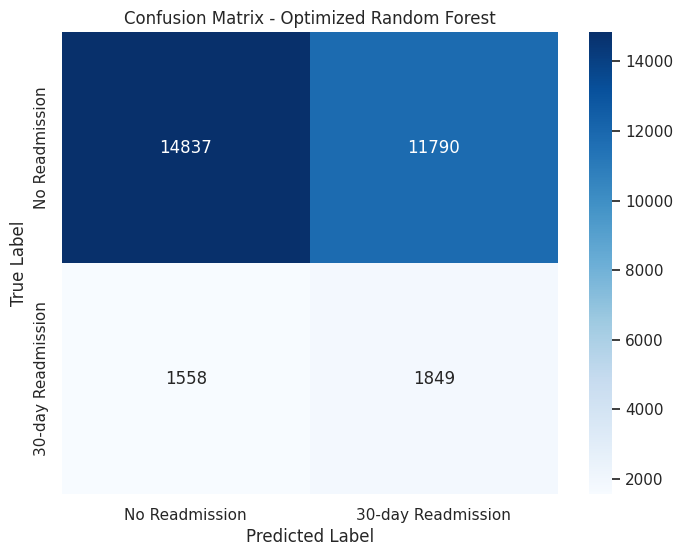


Confusion Matrix:
True Negatives: 14837
False Positives: 11790
False Negatives: 1558
True Positives: 1849


In [26]:

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

study.optimize(
    objective, 
    n_trials=200,
    # callbacks=[callback],
    show_progress_bar=True,
)

# Print optimization results
print(f"\nOptimization completed!")
print(f"Best parameters: {study.best_params}")
print(f"Best CV F1 score: {study.best_value:.4f}")

# Create final pipeline with best parameters
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Final CV F1 score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

# Train the final model on all training data
best_pipeline.fit(X_train, y_train)

# Evaluate on test set
y_pred_test = best_pipeline.predict(X_test)
y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\nFinal Test Performance:")
print(f"F1: {test_f1:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Save the best model for later use
best_rf_optimized = best_pipeline.named_steps['classifier']


# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

In [27]:
import joblib

print(study.best_params)
# Save the best pipeline model
joblib.dump(best_pipeline, 'best_diabetes_readmission_model_diag.pkl')
print("Model saved as 'best_diabetes_readmission_model.pkl'")

# Also save just the classifier if needed
joblib.dump(best_rf_optimized, 'best_classifier_only_diag.pkl')
print("Classifier saved as 'best_classifier_only.pkl'")

{'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.04154399655390885, 'subsample': 0.6076139290373725, 'colsample_bytree': 0.9179326816144487, 'reg_alpha': 0.7319776688516147, 'reg_lambda': 0.9113950459859058}
Model saved as 'best_diabetes_readmission_model.pkl'
Classifier saved as 'best_classifier_only.pkl'


In [28]:
from sklearn.ensemble import VotingClassifier

# Create ensemble of the two trained models

# Load the two best pipelines (assuming they were saved)
try:
    # Try to load the saved models
    pipeline_no_diag = joblib.load('best_diabetes_readmission_model.pkl')
    pipeline_diag_only = joblib.load('best_diabetes_readmission_model_diag.pkl')
    print("Loaded saved models successfully")
except:
    print("Using models from current session")
    # Use the models from the current session
    # Note: pipeline_no_diag would be from cell 25, pipeline_diag_only from cell 30

# Create ensemble using voting classifier
ensemble = VotingClassifier(
    estimators=[
        ('model_no_diag', pipeline_no_diag),
        ('model_diag_only', pipeline_diag_only)
    ],
    voting='soft',  # Use probability-based voting
    weights=[0.7, 0.3]  # Give more weight to the full feature model
)

print("Training ensemble model...")
# Train the ensemble on the original training data (without diagnosis features)
# We'll use the X_train and y_train from the original split (cell 15)



ensemble.fit(X_train, y_train)

print("Ensemble model trained successfully")

Loaded saved models successfully
Training ensemble model...
Ensemble model trained successfully


In [29]:
# SHAP Analysis for the optimized Random Forest
# We need to extract the classifier from the pipeline and use preprocessed data

# # Get the preprocessed test data by transforming through the pipeline steps
# X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# # Get the trained classifier from the pipeline
# trained_classifier = best_pipeline.named_steps['classifier']

# # Create SHAP explainer for the Random Forest classifier
# explainer = shap.TreeExplainer(trained_classifier)

# # Calculate SHAP values using the preprocessed test data
# # Note: Using a subset for faster computation
# sample_size = min(1000, len(X_test_preprocessed))
# X_test_sample = X_test_preprocessed[:sample_size]

# print(f"Computing SHAP values for {sample_size} test samples...")
# shap_values = explainer.shap_values(X_test_sample, check_additivity=False)

# # If binary classification, take the positive class SHAP values
# if isinstance(shap_values, list) and len(shap_values) == 2:
#     shap_values = shap_values[1]  # positive class

# # Get feature names from the preprocessor
# feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# # Create a DataFrame for easier handling
# X_test_sample_df = pd.DataFrame(X_test_sample, columns=feature_names)

# # Summary plot (bar)
# shap.summary_plot(shap_values, X_test_sample_df, plot_type='bar', show=False)
# plt.title('Mean SHAP Feature Importance - Optimized Random Forest')
# plt.tight_layout()
# plt.show()

# # Detailed summary plot
# shap.summary_plot(shap_values, X_test_sample_df, show=False)
# plt.title('SHAP Summary Plot - Optimized Random Forest')
# plt.tight_layout()
# plt.show()


